In [8]:
%pylab inline
from IPython.display import SVG
import nengo_spa as spa
import nengo
import scipy.linalg
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from scipy.stats import multivariate_normal
import nengolib

import nengo_spa
from nengo_spa.semantic_pointer import SemanticPointer
from nengo.utils.compat import is_array, is_array_like, is_number
from nengo_spa.algebras.hrr_algebra import HrrAlgebra
from nengo_spa.ast.base import Fixed, infer_types, TypeCheckedBinaryOp
from nengo_spa.types import TAnyVocab, TScalar, TVocabulary


from nengo.utils.ensemble import response_curves, tuning_curves
from nengo.utils.builder import default_n_eval_points

from ssp_grid_cell_utils import *

Populating the interactive namespace from numpy and matplotlib


/home/ns2dumon/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['multivariate_normal', 'connect']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


We want to represent an SSP $S(x(t),y(t))$ that is changing over time given the initial SSP $S(x(0),y(0))$ and velocity inputs $\dot{x}$, $\dot{y}$.

\begin{align}
\dot{S}(x(t), y(t)) &= \frac{d}{dt} \mathcal{F}^{-1} \{ \mathcal{F}\{X\}^{x(t)} \odot \mathcal{F}\{Y\}^{y(t)} \} \\
&= \sum_{j=0}^{d-1} \frac{d}{dt} (\mathcal{F}\{X\}_j^{x(t)} \mathcal{F}\{Y\}_j^{y(t)}) e^{i2\pi n j /d} \\
&= \sum_{j=0}^{d-1} \frac{d}{dt} (e^{i\theta_{x,j} x(t)}e^{i\theta_{y,j} y(t)}) e^{i2\pi n j /d} \\
&= \sum_{j=0}^{d-1} i(\dot{x}(t) \theta_{x,j} + \dot{y}(t) \theta_{y,j}) (e^{i\theta_{x,j} x(t)}e^{i\theta_{y,j} y(t)}) e^{i2\pi n j /d} \\
&= \sum_{j=0}^{d-1} i(\dot{x}(t) \theta_{x,j} + \dot{y}(t) \theta_{y,j}) \mathcal{F}\{X\}_j^{x(t)} \mathcal{F}\{Y\}_j^{y(t)} e^{i2\pi n j /d} \\
&=  \mathcal{F}^{-1} \{i(\dot{x}(t) \vec{\theta}_{x} + \dot{y}(t) \vec{\theta}_{y}) \odot \bar{X}^{x(t)} \odot \bar{Y}^{y(t)} \} \\
&= S(x(t), y(t)) \circledast  i\left(\dot{x}(t) \mathcal{F}^{-1} \{ \vec{\theta}_{x}\} +  \dot{y}(t)  \mathcal{F}^{-1} \{ \vec{\theta}_{y} \} \right ) \\
&= S(x(t), y(t)) \circledast  \left (\dot{x}(t) \mathcal{F}^{-1} \{ \ln \mathcal{F}\{ X\} \} +  \dot{y}(t)  \mathcal{F}^{-1} \{ \ln \mathcal{F}\{ Y\} \} \right )
\end{align}


In [9]:
K_hex = np.array([[0,1], [np.sqrt(3)/2,-0.5], [-np.sqrt(3)/2,-0.5]])

n_scales = 5
scales = np.linspace(0.8,1.8,n_scales)
K_scales = np.vstack([K_hex*i for i in scales])
n_rotates = 5
thetas = np.arange(0,n_rotates)*np.pi/(3*n_rotates)
R_mats = np.stack([np.stack([np.cos(thetas), -np.sin(thetas)],axis=1),
           np.stack([np.sin(thetas), np.cos(thetas)], axis=1)], axis=1)
K_rotates = (R_mats @ K_hex.T).transpose(1,2,0).T.reshape(-1,2)
K_scale_rotates = (R_mats @ K_scales.T).transpose(1,2,0).T.reshape(-1,2)
N = n_scales*n_rotates
X, Y = ssp_plane_basis(K_scale_rotates)
myK = K_scale_rotates
d = X.v.shape[0]

xy_rad = 10
xs = np.linspace(-xy_rad,xy_rad,100)
ys = np.linspace(-xy_rad,xy_rad,100)

The path to follow:

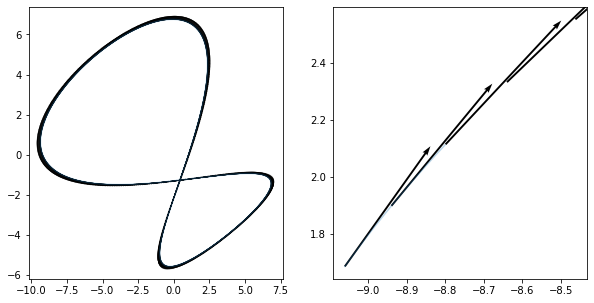

In [10]:
T = 20
dt = 0.001
timesteps = np.arange(0, T, dt)
#path,_ = generate_signal(T, dt, dims=2, rms=8,limit=0.05, seed=2)
#path = 3*np.vstack([np.sin(2*np.pi*timesteps/T),np.cos(2*np.pi*timesteps/T) - 1]).T
path,_ = generate_signal(T, dt, dims=2, rms=6,limit=0.1, seed=2)

pathlen = path.shape[0]
vels = (1/dt)*( path[(np.minimum(floor(timesteps/dt) + 1, pathlen-1)).astype(int),:] -
               path[(np.minimum(floor(timesteps/dt), pathlen-2)).astype(int),:])
max_v = np.max(np.abs(vels))
figure(figsize=(10,5))
subplot(1,2,1)
plot(path[:,0],path[:,1],alpha=0.3)
quiver(path[0::30,0],path[0::30,1], vels[0::30,0], vels[0::30,1], angles='xy', scale_units='xy',scale=2)
subplot(1,2,2)
plot(path[0:200,0],path[0:200,1],alpha=0.3)
quiver(path[0:500:100,0],path[0:500:100,1], vels[0:500:100,0], vels[0:500:100,1], angles='xy', scale_units='xy',scale=5)


def exact_ssp(t):
    S = ((X**path[int(t/dt)-1,0])*(Y**path[int(t/dt)-1,1])).v
    return S.real

def plot_sim_path(ts, ssp_p,path):
    tlen = ts.shape[0]
    sim_pts = np.zeros((tlen,2))
    sim_pt_dists = np.zeros(tlen)

    pt_confids = np.zeros(tlen)
    heatmap_t = np.zeros((len(xs),len(ys)))
    heatmap_vectors = get_heatmap_vectors(xs, ys, X, Y)
    for i in np.arange(tlen):
        heatmap_t = heatmap_t + np.tensordot(ssp_p[i,:].reshape(-1), heatmap_vectors, axes=([0], [2]))
        xt, yt, ptcon = loc_match(ssp_p[i,:].reshape(-1), heatmap_vectors, xs, ys)
        pt_confids[i] = ptcon
        sim_pts[i,:] = np.array([xt,yt])
        sim_pt_dists[i] = np.linalg.norm(sim_pts[i,:]-path[i,:])
        
    figure(figsize=(12,6))
    subplot(1,2,1)
    scatter(sim.trange(), sim_pt_dists, s=2, c = pt_confids, alpha=0.5)
    xlabel("time")
    ylabel("distance to true position")
    subplot(1,2,2)
    scatter(sim_pts[:,0], sim_pts[:,1],s=2, c = pt_confids, alpha=0.5)
    plot(path[:,0], path[:,1],'r')
    scatter(sim_pts[5,0], sim_pts[5,1],s=50, c="r",marker="+")
    colorbar()
    
    return sim_pts, sim_pt_dists, pt_confids

## Binding network path integrator 

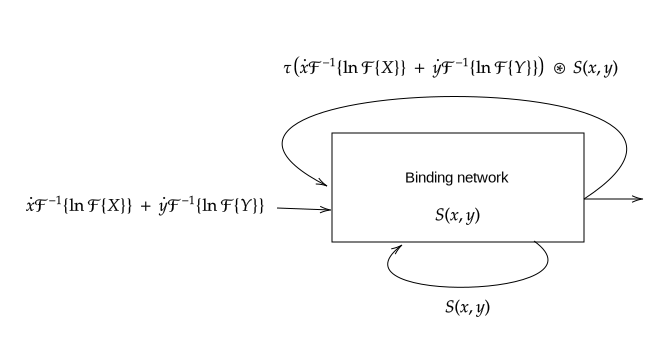

In [4]:
SVG(filename='diagram-20200821.svg')

In [11]:
n_neurons = 500
thetas = np.vstack([1.j * K_scale_rotates,np.zeros((1,2)),np.flip(-1.j * K_scale_rotates, axis=0)])
lnT = np.fft.ifft(np.fft.ifftshift(thetas), axis=0).real
lnT[:,[0, 1]] = lnT[:,[1, 0]]
lnX = lnT[:,0]
lnY = lnT[:,1]


max_mag = np.max(np.linalg.norm(vels[:,0].reshape(-1,1) * np.tile(lnX,(vels[:,0].shape[0],1))  +
               vels[:,1].reshape(-1,1) * np.tile(lnY,(vels[:,1].shape[0],1)),axis=1 ))

# From Terry:
tau=0.1
model = nengo.Network(seed=1)
with model:
    stim_v = nengo.Node(lambda t: vels[int(t/dt)-1,:])
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_ssp(t) if t<10*dt else np.zeros((d,)))
    
    def ssp_normalize(x):
        return x/np.maximum(1e-8,np.sum(x**2))
    
    path_int = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d,
                                                input_magnitude=max_mag)
    #path_int.output.output = lambda t, x: ssp_normalize(x) # normalizing helps in direct mode

    nengo.Connection(stim, path_int.output) #initialize
    nengo.Connection(stim_v, path_int.input_b, transform=lnT, synapse=tau)
    
    # do the "tau*dSSP" part of principle 3
    nengo.Connection(path_int.output, path_int.input_a, transform=tau, synapse=tau)
         
    # do the "+x" part of principle 3
    nengo.Connection(path_int.product.sq1.output, path_int.product.sq1.input,transform=0.5, synapse=tau)
    nengo.Connection(path_int.product.sq2.output, path_int.product.sq1.input,transform=0.5, synapse=tau)
    nengo.Connection(path_int.product.sq1.output, path_int.product.sq2.input,transform=0.5, synapse=tau)
    nengo.Connection(path_int.product.sq2.output, path_int.product.sq2.input,transform=0.5, synapse=tau)
  
    
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    ssp_p = nengo.Probe(path_int.output, synapse=.01)
    v_p = nengo.Probe(path_int.input_b, synapse=.01)

In direct mode:

In [37]:
nengo.utils.network.activate_direct_mode(model)
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

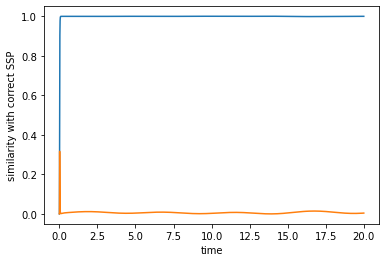

In [38]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
xlabel("time")
ylabel("similarity with correct SSP")

ssp_p_bn_dir = sim.data[ssp_p]

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:716: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


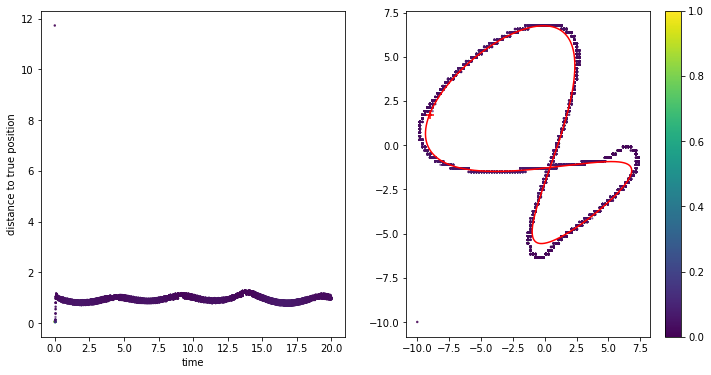

In [39]:
simpts_bn_dir, ptdists_bn_dir, ptconfid_bn_dir =  plot_sim_path(sim.trange(), sim.data[ssp_p], path)

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:459: ComplexWarning: Casting complex values to real discards the imaginary part
  S_list[:,i] = np.fft.ifft(np.prod(np.fft.fft(basis, axis=0)**positions[i,:], axis=1), axis=0)


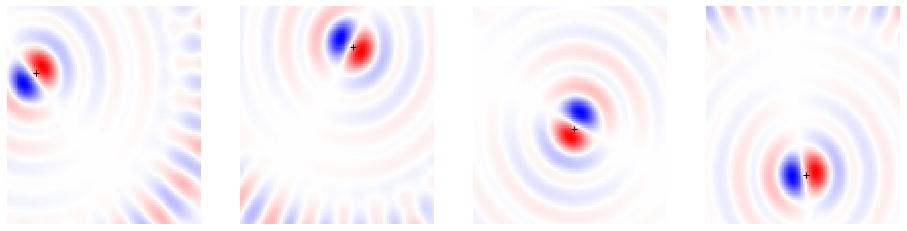

In [40]:
xx,yy = np.meshgrid(xs,ys)
basis = np.vstack([X.v, Y.v]).T
positions = np.vstack([xx.reshape(-1), yy.reshape(-1)]).T
position0 = np.array([0,0])
sim_dots0, S_list = similarity_values(basis,  positions, position0 = position0, S0 = sim.data[real_ssp_p][0,:])

fig, axs = plt.subplots(1,4,figsize=(16,4))
sample_t = np.linspace(1,10,  4)
for j in range(4):
    sim_dots, _ = similarity_values(basis,  positions, position0 = position0,
                                    S0 = sim.data[ssp_p][int(sample_t[j]/dt)-1,:], S_list = S_list)    
    axs[j].pcolormesh(xx, yy, sim_dots.reshape(xx.shape), cmap='bwr')#,vmin=-1,vmax=1)
    axs[j].plot(path[int(sample_t[j]/dt)-1,0], path[int(sample_t[j]/dt)-1,1], '+k')
    axs[j].axis('off')

In spiking mode:

In [41]:
for obj in model.all_ensembles:
    obj.neuron_type=nengo.neurons.LIF()
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

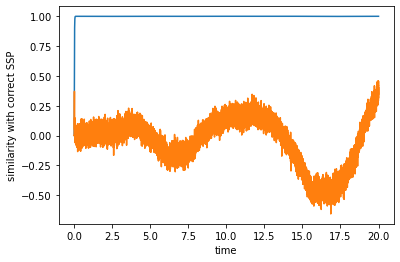

In [42]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
xlabel("time")
ylabel("similarity with correct SSP")

ssp_p_bn_sp = sim.data[ssp_p]

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:716: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


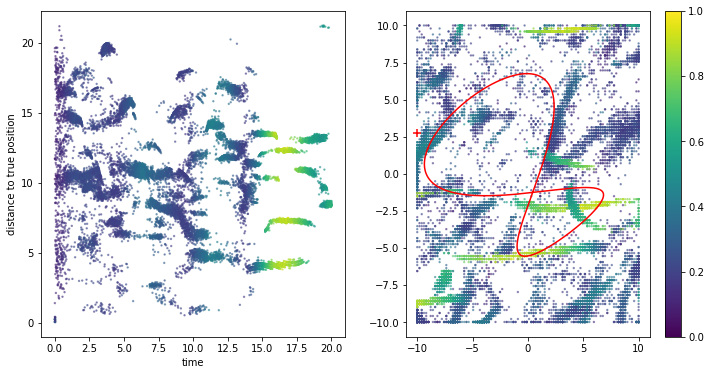

In [43]:
simpts_bn_sp, ptdists_bn_sp, ptconfid_bn_sp =  plot_sim_path(sim.trange(), sim.data[ssp_p], path)

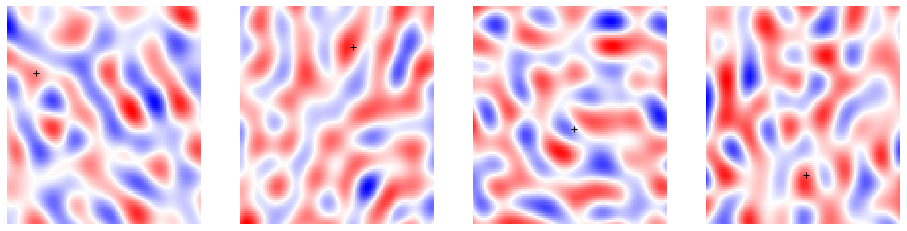

In [13]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
for j in range(4):
    sim_dots, _ = similarity_values(basis,  positions, position0 = position0,
                                    S0 = sim.data[ssp_p][int(sample_t[j]/dt)-1,:], S_list = S_list)    
    axs[j].pcolormesh(xx, yy, sim_dots.reshape(xx.shape), cmap='bwr')#,vmin=-1,vmax=1)
    axs[j].plot(path[int(sample_t[j]/dt)-1,0], path[int(sample_t[j]/dt)-1,1], '+k')
    axs[j].axis('off')

### Binding network path integrator with grid cell population doing the "+x"

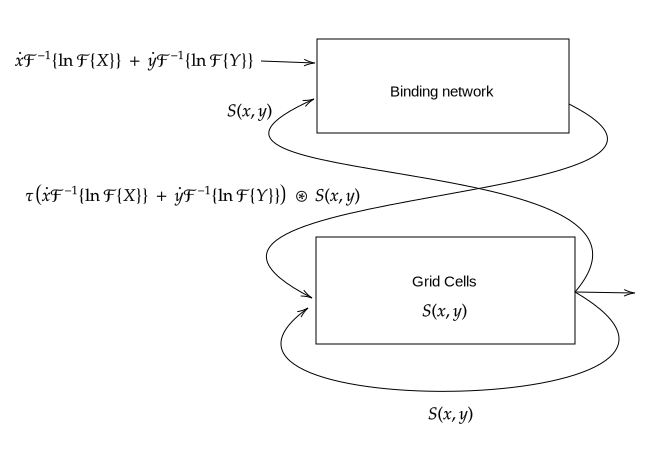

In [14]:
SVG(filename='diagram-20200821(1).svg')

(The network has been modified as per Terry's suggestion: the output of the binding network is also used input to the binding network)

In [12]:
n_G = 10000 # number of grid cells

G_pos_dist = nengolib.stats.Rd()
G_pos = G_pos_dist.sample(n_G,2)*2*xy_rad - xy_rad

G_sorts = np.hstack([np.arange(N), np.random.randint(0, N - 1, size = n_G - N)])
G_encoders = np.zeros((n_G,d))
for i in np.arange(n_G):
    sub_mat = get_sub_SSP(G_sorts[i],N)
    proj_mat = proj_sub_SSP(G_sorts[i],N)
    Xi = SemanticPointer(data = sub_mat @ X.v)
    Yi = SemanticPointer(data = sub_mat @ Y.v)
    G_encoders[i,:] = N * proj_mat @ ((Xi**G_pos[i,0])*(Yi**G_pos[i,1])).v
    
n_eval_pts = default_n_eval_points(n_G, d)
unif_dist = nengolib.stats.ScatteredHypersphere(True)
eval_xy = unif_dist.sample(n_eval_pts, 2)
eval_pts = ssp_vectorized(np.vstack([X.v, Y.v]).T, eval_xy).real.T

/home/ns2dumon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]
/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:459: ComplexWarning: Casting complex values to real discards the imaginary part
  S_list[:,i] = np.fft.ifft(np.prod(np.fft.fft(basis, axis=0)**positions[i,:], axis=1), axis=0)


In [12]:
model = nengo.Network(seed=1)
with model:
    stim_v = nengo.Node(lambda t: vels[int(t/dt)-1,:])
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_ssp(t) if t<30*dt else np.zeros((d,)))
    
    binding_ens = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d,
                                                input_magnitude=max_mag)
    
    gc_ens = nengo.Ensemble(n_G, dimensions=d, radius = 1, 
                         encoders = G_encoders, 
                        eval_points = eval_pts)
    
    nengo.Connection(stim, gc_ens) #initialize
    nengo.Connection(stim_v, binding_ens.input_b, transform=lnT, synapse=tau)
    
    def ssp_normalize(x):
        return x/np.maximum(1e-8,np.sum(x**2))
    
    nengo.Connection(binding_ens.output, gc_ens, synapse=tau,transform=tau)
    nengo.Connection(binding_ens.output, binding_ens.input_a, synapse=tau,transform=tau)
    #binding_ens.output.output = lambda t,x: ssp_normalize(x)
    nengo.Connection(gc_ens,gc_ens, synapse=tau,function=ssp_normalize)
    nengo.Connection(gc_ens,binding_ens.input_a, synapse=tau,function = ssp_normalize)
    
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    ssp_p = nengo.Probe(gc_ens, synapse=.01)
    ssp2_p = nengo.Probe(binding_ens.output, synapse=.01)

In direct mode:

In [13]:
nengo.utils.network.activate_direct_mode(model)
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

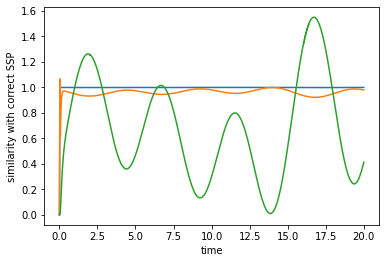

In [14]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp2_p]*sim.data[real_ssp_p], axis=1))
xlabel("time")
ylabel("similarity with correct SSP")

ssp_p_bngc_dir = sim.data[ssp_p]

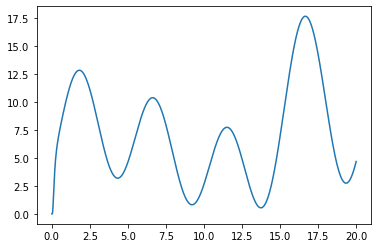

In [17]:
plot(sim.trange(),np.sum(sim.data[ssp2_p]*sim.data[ssp2_p], axis=1))


/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:716: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


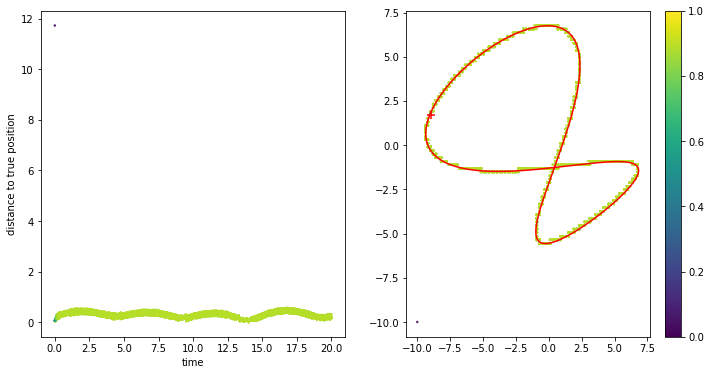

In [18]:
simpts_bngc_dir, ptdists_bngc_dir, ptconfid_bngc_dir =  plot_sim_path(sim.trange(), sim.data[ssp_p], path)

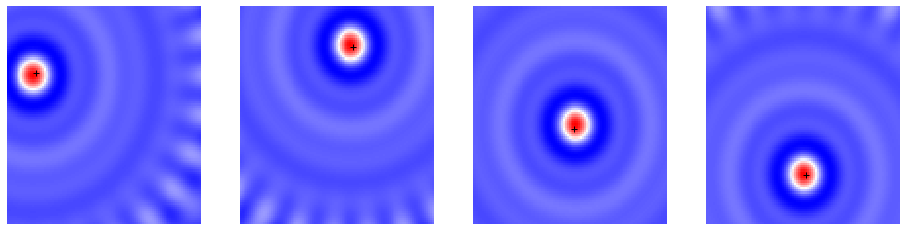

In [100]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
for j in range(4):
    sim_dots, _ = similarity_values(basis,  positions, position0 = position0,
                                    S0 = sim.data[ssp_p][int(sample_t[j]/dt)-1,:], S_list = S_list)    
    axs[j].pcolormesh(xx, yy, sim_dots.reshape(xx.shape), cmap='bwr')#,vmin=-1,vmax=1)
    axs[j].plot(path[int(sample_t[j]/dt)-1,0], path[int(sample_t[j]/dt)-1,1], '+k')
    axs[j].axis('off')

Why is using a grid cell population so helpful?

SSPs are represented more accurately from grid cell populations. Note that least squares problem of decoding sampled SSPs from a population of neurons will look like the optimization problem of decoding place cell output - except that instead of $\Sigma$ being correlation matrix of place cell outputs, it is the correlation matrix of SSPs. A large matrix whose entries are dot products of SSPs uniformly covering space. From "A short letter on the dot productbetween rotated Fourier transforms", we know that these entries are samples of products of sinc functions. This matrix should be, in the limit of large numbers, transitional invariant and circularly symmetric (i.e. circulant). So it has the same important features as the place cell correlation matrix that leads to the conclusion that optimal neuron activitites are hexagonally patterned.



In spiking mode:


In [32]:
model = nengo.Network(seed=1)
with model:
    stim_v = nengo.Node(lambda t: vels[int(t/dt)-1,:])
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_ssp(t) if t<30*dt else np.zeros((d,)))
    
    binding_ens = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d,
                                                input_magnitude=max_mag)
    
    gc_ens = nengo.Ensemble(n_G, dimensions=d, radius = 1, 
                         encoders = G_encoders, 
                        eval_points = eval_pts)
    
    nengo.Connection(stim, gc_ens) #initialize
    nengo.Connection(stim_v, binding_ens.input_b, transform=lnT, synapse=tau)
    
    def ssp_normalize(x):
        return x/np.maximum(1e-8,np.sum(x**2))
    def ssp_normalize2(x):
        return tau*x/np.maximum(1e-8,np.sum(x**2))
    
    nengo.Connection(binding_ens.output, gc_ens, synapse=tau,transform=tau)
    nengo.Connection(binding_ens.output, binding_ens.input_a, synapse=tau,transform=tau)
    binding_ens.output.output = lambda t,x: ssp_normalize(x)
    nengo.Connection(gc_ens,gc_ens, synapse=tau,function=ssp_normalize)
    nengo.Connection(gc_ens,binding_ens.input_a, synapse=tau)
    
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    ssp_p = nengo.Probe(gc_ens, synapse=.01)
    ssp2_p = nengo.Probe(binding_ens.output, synapse=.01)
    
nengo.utils.network.activate_direct_mode(model)

sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

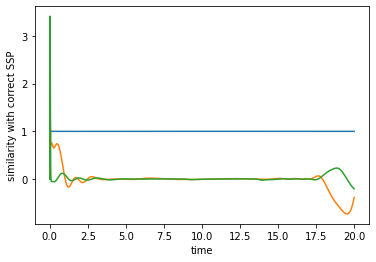

In [33]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp2_p]*sim.data[real_ssp_p], axis=1))
xlabel("time")
ylabel("similarity with correct SSP")

ssp_p_bngc_sp = sim.data[ssp_p]

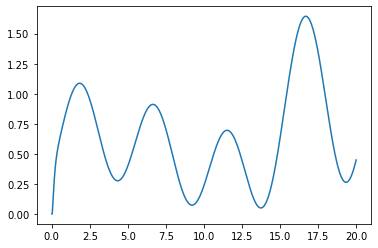

In [31]:
plot(sim.trange(),np.sum(sim.data[ssp2_p]*sim.data[ssp2_p], axis=1))


/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:716: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


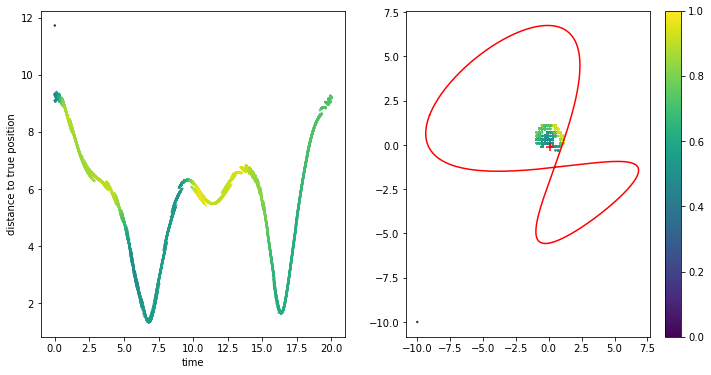

In [24]:
simpts_bngc_sp, ptdists_bngc_sp, ptconfid_bngc_sp =  plot_sim_path(sim.trange(), sim.data[ssp_p], path)

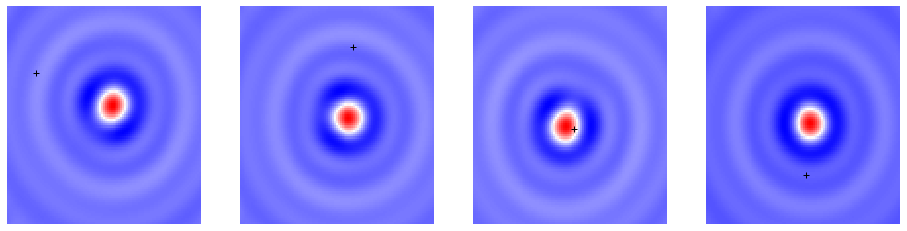

In [24]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
for j in range(4):
    sim_dots, _ = similarity_values(basis,  positions, position0 = position0,
                                    S0 = sim.data[ssp_p][int(sample_t[j]/dt)-1,:], S_list = S_list)    
    axs[j].pcolormesh(xx, yy, sim_dots.reshape(xx.shape), cmap='bwr')#,vmin=-1,vmax=1)
    axs[j].plot(path[int(sample_t[j]/dt)-1,0], path[int(sample_t[j]/dt)-1,1], '+k')
    axs[j].axis('off')

## VCO & grid cells path integrator

Each ensemble in the ensemble array is representing the real and imaginary component of $\mathcal{F}\{ S\}_j = \bar{S}_j$ and the value $\dot{x} \theta_{x,j} + \dot{y}\theta_{y,j}$:
\begin{equation}
\begin{bmatrix}
 \dot{x} \theta_{x,j} + \dot{y}\theta_{y,j} \\
 \text{Re}(\bar{S}_j) \\
 \text{Im}(\bar{S}_j)
\end{bmatrix}
\end{equation}
This will be updated via velocity input and a recurrent connection:
\begin{align}
\begin{bmatrix}
0 \\
 -\tau(\dot{x}(t) \theta_{x,j} +  \dot{y}(t)  \theta_{y,j})\text{Im}(\bar{S}_j) + \text{Re}(\bar{S}_j) \\
 \tau(\dot{x}(t) \theta_{x,j} +  \dot{y}(t)  \theta_{y,j})\text{Re}(\bar{S}_j) + \text{Im}(\bar{S}_j)
\end{bmatrix} 
\end{align}

Note that this is like an oscillator with frequency $\dot{x}(t) \theta_{x,j} +  \dot{y}(t)  \theta_{y,j} = \vec{v} \cdot \vec{\theta}_j$. It's a velocity controlled oscillator (VCO) - a popular model for grid cells and path integration. 

The results of the set of populations representing $\bar{S}_j$ for $j=0,\dots, d//2$ can be linearly transformed to get the SSP $S(t)$, this will be represented by a population of grid cells

Comments on connection btwn SSP, VCOs, and continuous attractors:

An d-dim SSP lies on a d-Clifford torus. "A fundamental result states that the phase space trajectories of a Hamiltonian with n degrees of freedom lie on an n-dimensional manifold which is topologically equivalent to an n-torus" -- e.g. the phase space trajectories of a harmonic oscillator lie on a circle. The phase space trajectories of a set of d harmonic oscillators lie on the cartesian product of d circles - the definition of a d-Clifford torus. 

So moving around in a particular way corresponding to the input velocities on the d-Clifford torus (dynamics of the SSP) is equivalent to having a set of d harmonic oscillators whose motion depends on the input velocities in a particular way. 

What about continous attractor models of path integration? These are models of a dynamical system with a toroidal continuous attractor. Again, it's moving around a torus in a particular way that depends on the input velocities.


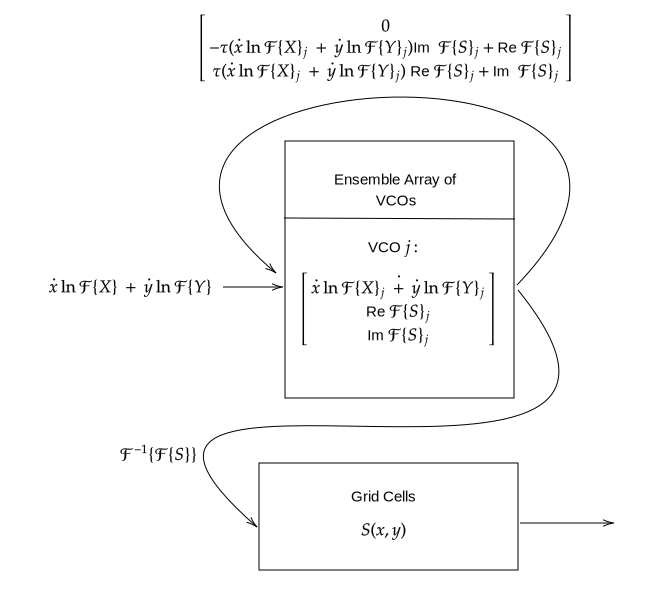

In [25]:
SVG(filename='diagram-20200821(2).svg')

In [13]:
myK = K_scale_rotates


n_oscs = d//2
real_ids = np.arange(1,n_oscs*3,3)
imag_ids = np.arange(2,n_oscs*3,3)
S_ids = np.zeros(n_oscs*2 + 1, dtype=int)
S_ids[0:d//2] = real_ids
S_ids[d//2:(n_oscs*2)] = imag_ids
S_ids[-1] = n_oscs*3 
i_S_ids = np.argsort(S_ids)

def exact_Fssp(t):
    S = exact_ssp(t)
    FS = np.fft.fftshift(np.fft.fft(S))
    realpart = FS.real[0:d//2]
    imagpart = FS.imag[0:d//2]
    res = np.zeros(d-1,)
    res[0:d//2] = realpart
    res[d//2:] = imagpart
    return res.real


def get_to_SSP_mat(D):
    W = np.fft.ifft(np.eye(D))
    W1 = W.real @ np.fft.ifftshift(np.eye(D),axes=0)
    W2 = W.imag @ np.fft.ifftshift(np.eye(D),axes=0)
    shiftmat1 = np.vstack([np.eye(D//2), np.zeros((1,D//2)), np.flip(np.eye(D//2), axis=0)])
    shiftmat2 = np.vstack([np.eye(D//2), np.zeros((1,D//2)), -np.flip(np.eye(D//2), axis=0)])
    shiftmat = np.vstack([ np.hstack([shiftmat1, np.zeros(shiftmat2.shape)]),
                          np.hstack([np.zeros(shiftmat2.shape), shiftmat2])])
    shiftmat = np.hstack([shiftmat, np.zeros((shiftmat.shape[0],1))])
    shiftmat[D//2,-1] = 1
    tr = np.hstack([W1, -W2]) @ shiftmat 
    return tr

def get_from_SSP_mat(D):
    W = np.fft.fft(np.eye(D))
    W1 = np.fft.fftshift(np.eye(D),axes=0) @ W.real 
    W2 = np.fft.fftshift(np.eye(D),axes=0) @ W.imag 
    shiftmat1 = np.hstack([np.eye(D//2), np.zeros((D//2, 2*(D//2) + D//2 + 2))])
    shiftmat2 = np.hstack([np.zeros((D//2, 2*(D//2) + 1)), np.eye(D//2), np.zeros((D//2, D//2 + 1))])
    shiftmat = np.vstack([ shiftmat1,shiftmat2])
    tr = shiftmat @ np.vstack([W1, W2]) 
    return tr

def as_SSP(x):
    r = np.maximum(np.sqrt(x[0:d//2]**2 + x[d//2:]**2), 1e-9)
    complex_x = (x[0:d//2] + 1.j*x[d//2:])/r
    complex_x = np.hstack([complex_x, 1, np.conj(complex_x)])
    return np.fft.ifft(np.fft.ifftshift(complex_x)).real

to_SSP = get_to_SSP_mat(d)
i_to_SSP = get_from_SSP_mat(d)


taus = 0.1*np.ones(n_oscs)
real_freqs = (vels @ myK.T)
scale_fac = 2/(np.max(real_freqs) - np.min(real_freqs))
vels_scaled = vels*scale_fac

model = nengo.Network(seed=1)
with model:
    vel_stim = nengo.Node(lambda t: vels_scaled[int(t/dt)-1,:], size_out=2)
    vel_input = nengo.Ensemble(n_neurons, dimensions=2,label='velocity')
    FS_real = nengo.Node(exact_Fssp) # just for probes
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_Fssp(t) if t<10*dt else np.zeros((d-1,)))
    stim2 = nengo.Node(lambda t: exact_ssp(t) if t<10*dt else np.zeros((d,)))
    node1 = nengo.Node([1,0,0])
    
    osc = nengo.networks.EnsembleArray(n_neurons, n_oscs + 1, ens_dimensions = 3,radius=np.sqrt(3), label="osc")
    osc.output.output = lambda t, x: x # a hack
    S_out = nengo.Ensemble(n_G, dimensions=d, encoders = G_encoders, radius=np.sqrt(2), label="Sout")
    
    # We want dynamics with a unit circle limit cycle that is stable
    
    # Harmonic oscillator: simple but limit cycle is unstable :'(
    def feedback(x, tau): 
        w = x[0]/scale_fac
        dx1 = - x[2]*w
        dx2 =  x[1]*w
        return 0, tau*dx1 + x[1], tau*dx2 + x[2]
    
    # From \dot{r} = (1-r^2), \dot{theta}=2\pi freq
    def feedback_stable(x, tau):
        w = x[0]/(scale_fac)
        r = np.maximum(np.sqrt(x[1]**2 + x[2]**2), 1e-5)
        dx1 = x[1]*(1-r**2)/r - x[2]*w 
        dx2 = x[2]*(1-r**2)/r + x[1]*w 
        return 0, tau*dx1 + x[1], tau*dx2 + x[2] 
    
    def feedback_stable2(x, tau):
        w = x[0]/scale_fac
        r = np.maximum(np.sqrt(x[1]**2 + x[2]**2), 1e-5)
        dx1 = x[1]*(1-r**2)/r - x[2]*w 
        dx2 = x[2]*(1-r**2)/r + x[1]*w 
        return 0, tau*dx1, tau*dx2
    
    
    nengo.Connection(vel_stim, vel_input)
    for i in np.arange(n_oscs):
        nengo.Connection(vel_input, osc.ea_ensembles[i][0], transform = myK[i,:].reshape(1,-1),  
                         synapse=taus[i])
        nengo.Connection(stim[i], osc.ea_ensembles[i][1]) #initialize
        nengo.Connection(stim[i + d//2], osc.ea_ensembles[i][2]) #initialize
        nengo.Connection(osc.ea_ensembles[i], osc.ea_ensembles[i], 
                         function=lambda x: feedback_stable(x, taus[i]), #recurrent connection
                         synapse=taus[i])
        
    nengo.Connection(node1, osc.ea_ensembles[-1])
    connect = nengo.Connection(osc.output[S_ids], S_out, transform = to_SSP, synapse=taus[0])

    
    real_p = nengo.Probe(FS_real, synapse=.01)
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    osc_p = nengo.Probe(osc.output, synapse=.01)
    ssp_p = nengo.Probe(S_out, synapse=.01)



In direct mode:

In [50]:
nengo.utils.network.activate_direct_mode(model)
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

Examples of oscillators:

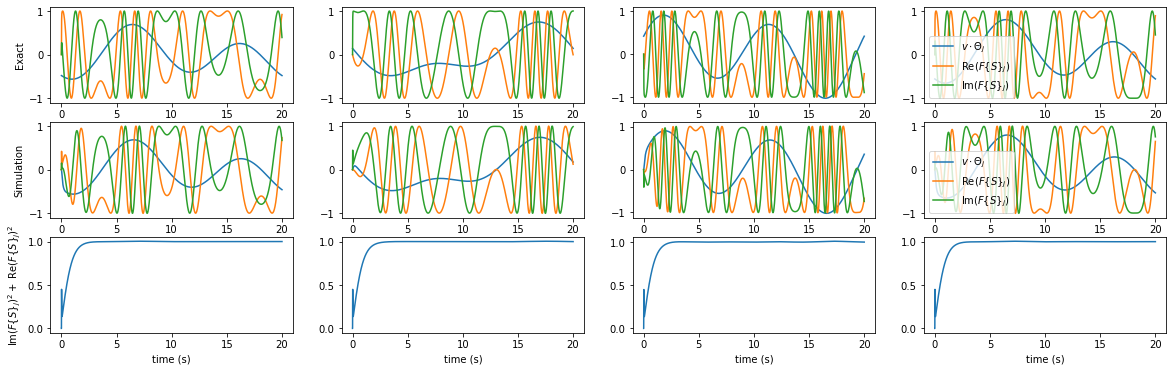

In [51]:
real_freqs_s = (vels_scaled @ myK.T)

sub_n_oscs = 4
figure(figsize=(20,6))
for i in np.arange(sub_n_oscs):
        
    j = i+ n_oscs - sub_n_oscs
    subplot(3,sub_n_oscs,i+1 )
    plot(sim.trange(), real_freqs_s[:, j])
    plot(sim.trange(), sim.data[real_p][:,[j, j + int(d//2)]])
    if i==sub_n_oscs-1:
        legend(["$v \cdot \Theta_{j}$","Re$( F\{S\}_j)$","Im$(F\{S\}_j)$"])
    if i==0:
        ylabel("Exact")
    
    subplot(3,sub_n_oscs, i+1 + sub_n_oscs)
    plot(sim.trange(), sim.data[osc_p][:,(3*j):3*(j+1)])
    if i==sub_n_oscs-1:
        legend(["$v \cdot \Theta_{j}$","Re$(F\{S\}_j)$","Im$(F\{S\}_j)$"])
    if i==0:
        ylabel("Simulation")
    
    subplot(3,sub_n_oscs, i+1 + 2*sub_n_oscs)
    plot(sim.trange(), np.sqrt( sim.data[osc_p][:,3*j+1]**2 +  sim.data[osc_p][:,3*(j+1)-1]**2 ))
    if i==0:
        ylabel("Im$(F\{S\}_j)^2 + $ Re$(F\{S\}_j)^2$")
    xlabel("time (s)")

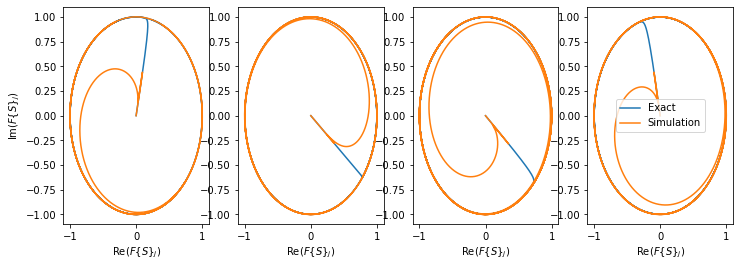

In [52]:
figure(figsize=(12,4))
for i in np.arange(sub_n_oscs):
    subplot(1,sub_n_oscs,i+1)
    plot(sim.data[real_p][:,i],  sim.data[real_p][:,i+ int(d//2)])
    plot(sim.data[osc_p][:,(3*i+1)], sim.data[osc_p][:,3*(i+1)-1])
    xlabel("Re$(F \{S\}_j)$")
    if i==0:
        ylabel("Im$(F\{S\}_j)$")
    if i==sub_n_oscs-1:
        legend(["Exact","Simulation"])

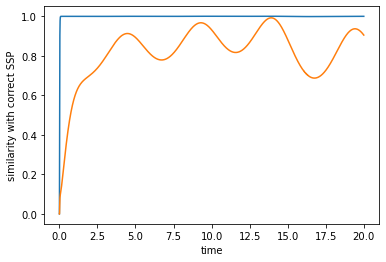

In [53]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
xlabel("time")
ylabel("similarity with correct SSP")

ssp_p_vco_dir = sim.data[ssp_p]

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:716: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


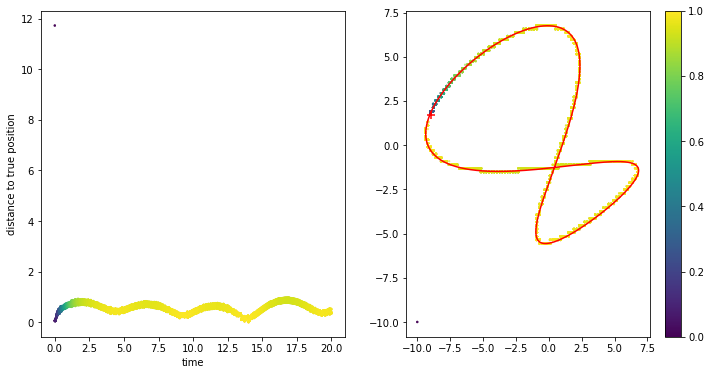

In [32]:
simpts_vco_dir, ptdists_vco_dir, ptconfid_vco_dir =  plot_sim_path(sim.trange(), sim.data[ssp_p], path)

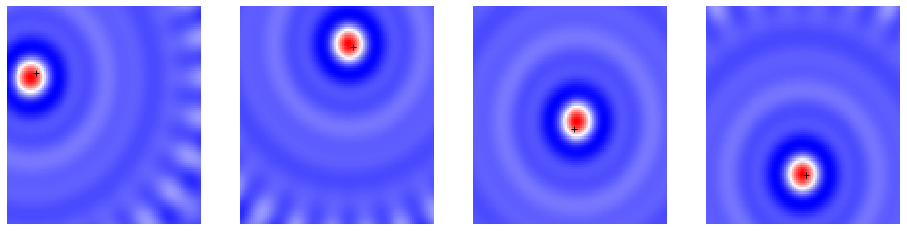

In [33]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
for j in range(4):
    sim_dots, _ = similarity_values(basis,  positions, position0 = position0,
                                    S0 = sim.data[ssp_p][int(sample_t[j]/dt)-1,:], S_list = S_list)    
    axs[j].pcolormesh(xx, yy, sim_dots.reshape(xx.shape), cmap='bwr')#,vmin=-1,vmax=1)
    axs[j].plot(path[int(sample_t[j]/dt)-1,0], path[int(sample_t[j]/dt)-1,1], '+k')
    axs[j].axis('off')

In spiking mode:

In [14]:
#with model:
 #   connect.synapse = None

for obj in model.all_ensembles:
    obj.neuron_type=nengo.neurons.LIF() 
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

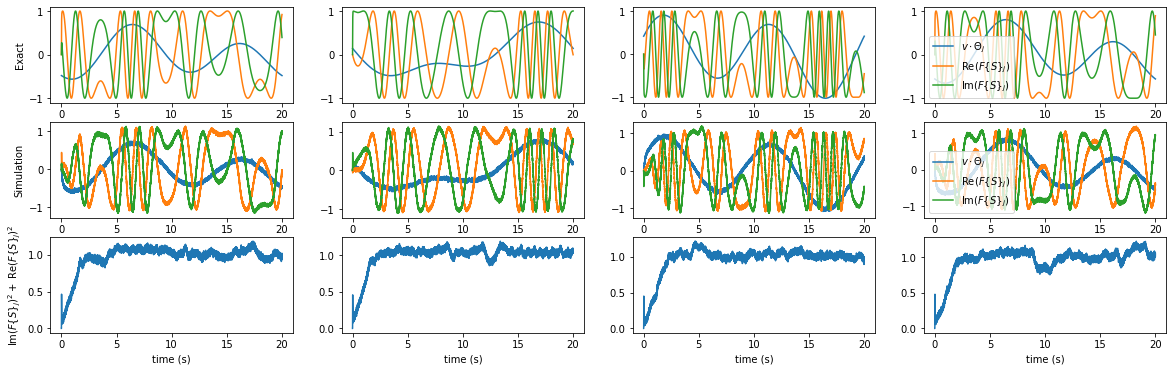

In [55]:
figure(figsize=(20,6))
for i in np.arange(sub_n_oscs):
        
    j = i+ n_oscs - sub_n_oscs
    subplot(3,sub_n_oscs,i+1 )
    plot(sim.trange(), real_freqs_s[:, j])
    plot(sim.trange(), sim.data[real_p][:,[j, j + int(d//2)]])
    if i==sub_n_oscs-1:
        legend(["$v \cdot \Theta_{j}$","Re$( F\{S\}_j)$","Im$(F\{S\}_j)$"])
        
    if i==0:
        ylabel("Exact")
    
    subplot(3,sub_n_oscs, i+1 + sub_n_oscs)
    plot(sim.trange(), sim.data[osc_p][:,(3*j):3*(j+1)])
    if i==sub_n_oscs-1:
        legend(["$v \cdot \Theta_{j}$","Re$(F\{S\}_j)$","Im$(F\{S\}_j)$"])
    if i==0:
        ylabel("Simulation")
    
    subplot(3,sub_n_oscs, i+1 + 2*sub_n_oscs)
    plot(sim.trange(), np.sqrt( sim.data[osc_p][:,3*j+1]**2 +  sim.data[osc_p][:,3*(j+1)-1]**2 ))
    if i==0:
        ylabel("Im$(F\{S\}_j)^2 + $ Re$(F\{S\}_j)^2$")
    xlabel("time (s)")

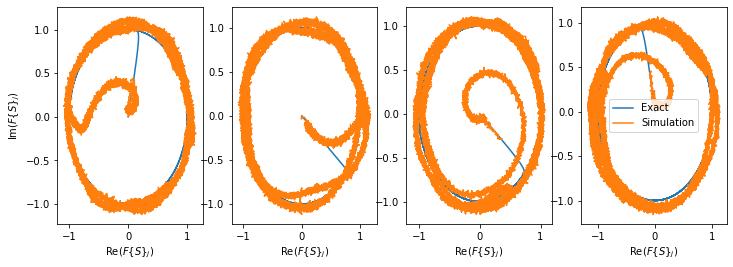

In [56]:
figure(figsize=(12,4))
for i in np.arange(sub_n_oscs):
    subplot(1,sub_n_oscs,i+1)
    plot(sim.data[real_p][:,i],  sim.data[real_p][:,i+ int(d//2)])
    plot(sim.data[osc_p][:,(3*i+1)], sim.data[osc_p][:,3*(i+1)-1])
    xlabel("Re$(F \{S\}_j)$")
    if i==0:
        ylabel("Im$(F\{S\}_j)$")
    if i==sub_n_oscs-1:
        legend(["Exact","Simulation"])

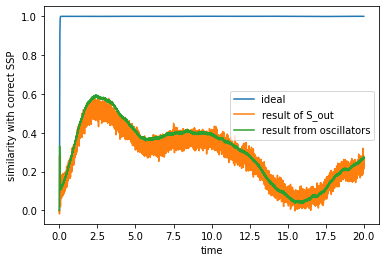

In [57]:
res_osc = (to_SSP @ sim.data[osc_p][:,S_ids].T).T

figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(res_osc*sim.data[real_ssp_p], axis=1))
legend(["ideal","result of S_out", "result from oscillators"])
xlabel("time")
ylabel("similarity with correct SSP")

ssp_p_vco_sp = sim.data[ssp_p]

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:716: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


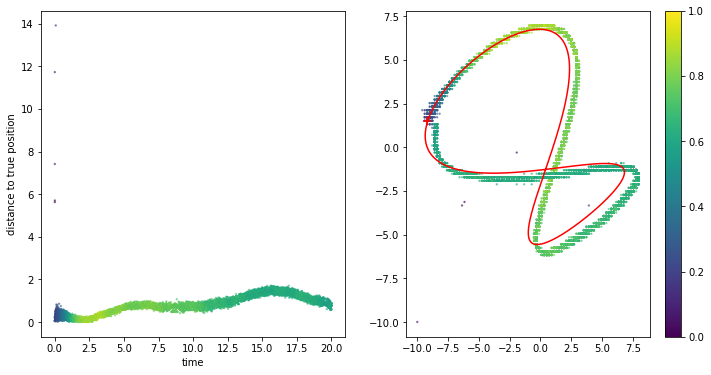

In [58]:
simpts_vco_sp, ptdists_vco_sp, ptconfid_vco_sp =  plot_sim_path(sim.trange(), sim.data[ssp_p], path)

From the oscillators (i.e. ignore noise from the pop post Fourier transform): 

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:716: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


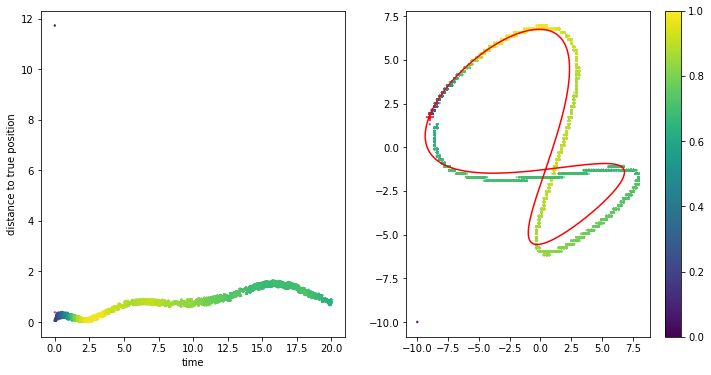

In [39]:
simpts_vco_sp2, ptdists_vco_sp2, ptconfid_vco_sp2 =  plot_sim_path(sim.trange(), res_osc, path)

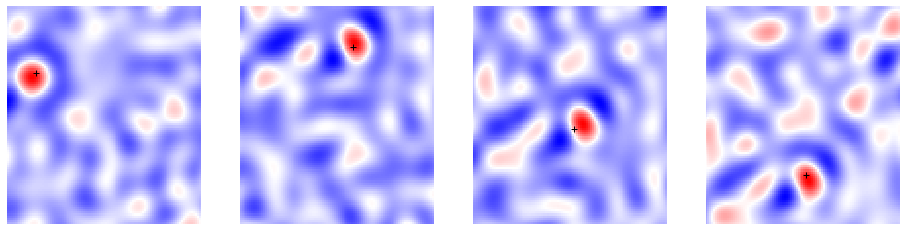

In [40]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
for j in range(4):
    sim_dots, _ = similarity_values(basis,  positions, position0 = position0,
                                    S0 = sim.data[ssp_p][int(sample_t[j]/dt)-1,:], S_list = S_list)    
    axs[j].pcolormesh(xx, yy, sim_dots.reshape(xx.shape), cmap='bwr')#,vmin=-1,vmax=1)
    axs[j].plot(path[int(sample_t[j]/dt)-1,0], path[int(sample_t[j]/dt)-1,1], '+k')
    axs[j].axis('off')

### With feedback from the grid cell population to the VCOs as a part of the dynamics

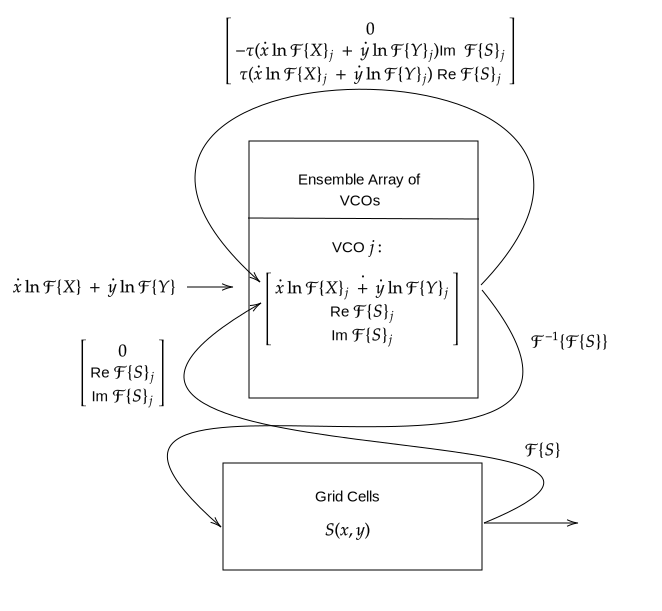

In [41]:
SVG(filename='diagram-20200821(3).svg')

In [40]:
#from nengolib import Alpha
tau = 0.1

model = nengo.Network(seed=1)
with model:
    vel_stim = nengo.Node(lambda t: vels_scaled[int(t/dt)-1,:], size_out=2)
    vel_input = nengo.Ensemble(n_neurons, dimensions=2,label='velocity')
    FS_real = nengo.Node(exact_Fssp) # just for probes
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_Fssp(t) if t<10*dt else np.zeros((d-1,)))
    stim2 = nengo.Node(lambda t: exact_ssp(t) if t<10*dt else np.zeros((d,)))
    node1 = nengo.Node([1,0,0])
    
    osc = nengo.networks.EnsembleArray(n_neurons, n_oscs + 1, ens_dimensions = 3,radius=np.sqrt(3), label="osc")
    osc.output.output = lambda t, x: x # a hack
    S_out = nengo.Ensemble(n_G, dimensions=d, encoders = G_encoders, eval_points=eval_pts, radius=np.sqrt(2), label="Sout")
    
    
    def feedback_stable2(x, tau):
        w = x[0]/scale_fac
        r = np.maximum(np.sqrt(x[1]**2 + x[2]**2), 1e-5)
        dx1 = x[1]*(1-r**2)/r - x[2]*w 
        dx2 = x[2]*(1-r**2)/r + x[1]*w 
        return 0, tau*dx1, tau*dx2
    

    
    to_SSP = get_to_SSP_mat(d)
    i_to_SSP = get_from_SSP_mat(d)
    
    nengo.Connection(vel_stim, vel_input)
    for i in np.arange(n_oscs):
        nengo.Connection(vel_input, osc.ea_ensembles[i][0], transform = myK[i,:].reshape(1,-1),  
                         synapse=taus[i])
        nengo.Connection(osc.ea_ensembles[i], osc.ea_ensembles[i], 
                         function= lambda x: feedback_stable2(x, taus[i]), 
                         synapse=taus[i])
        
        S_back_mat = i_to_SSP[i_S_ids[2*i:(2*i+2)],:]
        nengo.Connection(S_out, osc.ea_ensembles[i][1:], transform=S_back_mat, synapse=tau)
        
    nengo.Connection(node1, osc.ea_ensembles[-1])
    nengo.Connection(osc.output[S_ids], S_out, transform = to_SSP, synapse=tau) 
    nengo.Connection(S_out, S_out, synapse=tau) 
    
    nengo.Connection(stim2, S_out)
    
    real_p = nengo.Probe(FS_real, synapse=.01)
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    osc_p = nengo.Probe(osc.output, synapse=.01)
    ssp_p = nengo.Probe(S_out, synapse=.01)



In direct mode:

In [41]:
nengo.utils.network.activate_direct_mode(model)
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

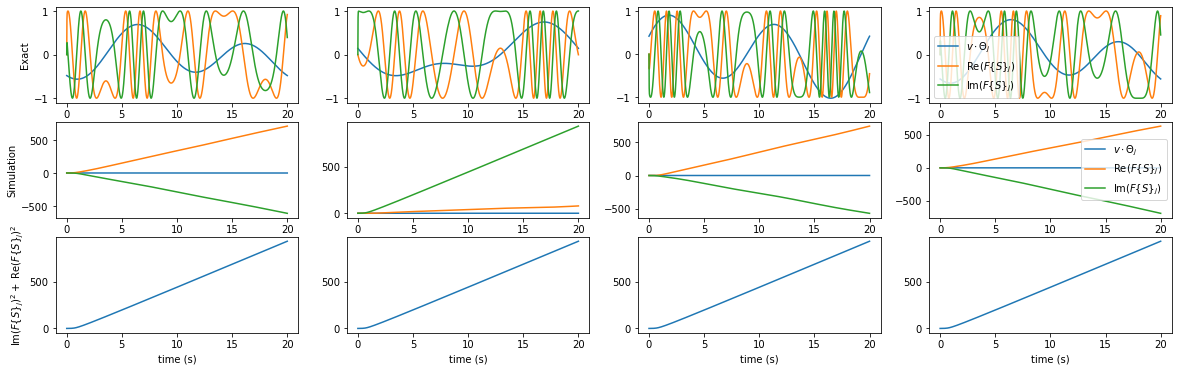

In [42]:
sub_n_oscs=4
real_freqs_s = (vels_scaled @ myK.T)
figure(figsize=(20,6))
for i in np.arange(sub_n_oscs):
        
    j = i+ n_oscs - sub_n_oscs
    subplot(3,sub_n_oscs,i+1 )
    plot(sim.trange(), real_freqs_s[:, j])
    plot(sim.trange(), sim.data[real_p][:,[j, j + int(d//2)]])
    if i==sub_n_oscs-1:
        legend(["$v \cdot \Theta_{j}$","Re$( F\{S\}_j)$","Im$(F\{S\}_j)$"])
    if i==0:
        ylabel("Exact")
    
    subplot(3,sub_n_oscs, i+1 + sub_n_oscs)
    plot(sim.trange(), sim.data[osc_p][:,(3*j):3*(j+1)])
    if i==sub_n_oscs-1:
        legend(["$v \cdot \Theta_{j}$","Re$(F\{S\}_j)$","Im$(F\{S\}_j)$"])
    if i==0:
        ylabel("Simulation")
    
    subplot(3,sub_n_oscs, i+1 + 2*sub_n_oscs)
    plot(sim.trange(), np.sqrt( sim.data[osc_p][:,3*j+1]**2 +  sim.data[osc_p][:,3*(j+1)-1]**2 ))
    if i==0:
        ylabel("Im$(F\{S\}_j)^2 + $ Re$(F\{S\}_j)^2$")
    xlabel("time (s)")

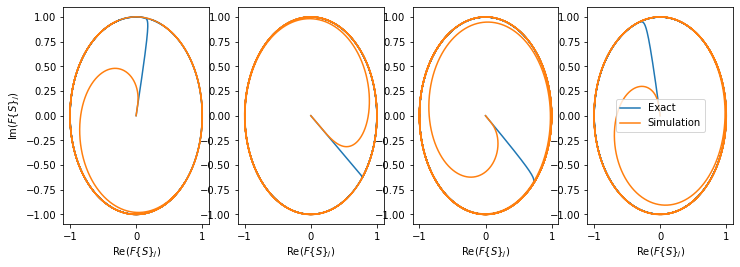

In [52]:
figure(figsize=(12,4))
for i in np.arange(sub_n_oscs):
    subplot(1,sub_n_oscs,i+1)
    plot(sim.data[real_p][:,i],  sim.data[real_p][:,i+ int(d//2)])
    plot(sim.data[osc_p][:,(3*i+1)], sim.data[osc_p][:,3*(i+1)-1])
    xlabel("Re$(F \{S\}_j)$")
    if i==0:
        ylabel("Im$(F\{S\}_j)$")
    if i==sub_n_oscs-1:
        legend(["Exact","Simulation"])

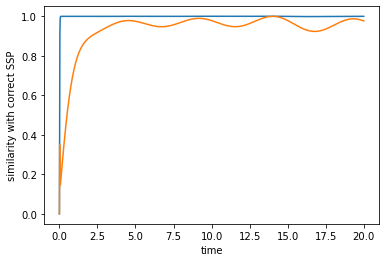

In [53]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
xlabel("time")
ylabel("similarity with correct SSP")

ssp_p_vcofeedback_sp = sim.data[ssp_p]

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:716: ComplexWarning: Casting complex values to real discards the imaginary part
  vectors[i, j, :] = p.v


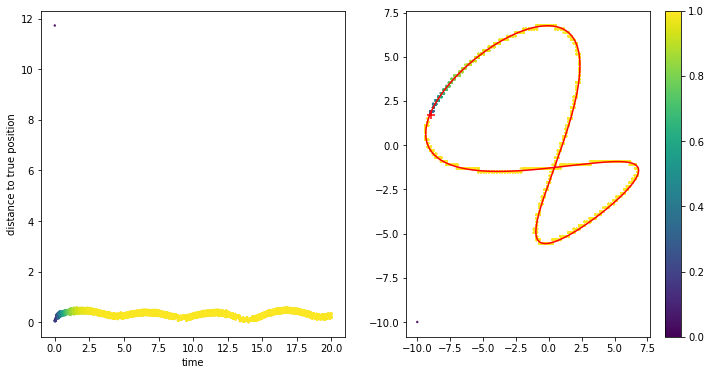

In [54]:
simpts_vcofeedback_sp, ptdists_vcofeedback_sp, ptconfid_vcofeedback_sp =  plot_sim_path(sim.trange(),
                                                                                        sim.data[ssp_p], path)

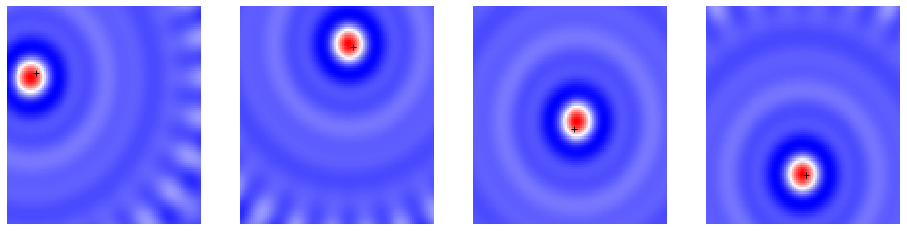

In [62]:
fig, axs = plt.subplots(1,4,figsize=(16,4))
for j in range(4):
    sim_dots, _ = similarity_values(basis,  positions, position0 = position0,
                                    S0 = sim.data[ssp_p][int(sample_t[j]/dt)-1,:], S_list = S_list)    
    axs[j].pcolormesh(xx, yy, sim_dots.reshape(xx.shape), cmap='bwr')#,vmin=-1,vmax=1)
    axs[j].plot(path[int(sample_t[j]/dt)-1,0], path[int(sample_t[j]/dt)-1,1], '+k')
    axs[j].axis('off')

In spiking mode:

In [15]:
# Doesn't work


model = nengo.Network(seed=1)
with model:
    vel_stim = nengo.Node(lambda t: vels_scaled[int(t/dt)-1,:], size_out=2)
    vel_input = nengo.Ensemble(n_neurons, dimensions=2,label='velocity')
    FS_real = nengo.Node(exact_Fssp) # just for probes
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_Fssp(t) if t<10*dt else np.zeros((d-1,)))
    stim2 = nengo.Node(lambda t: exact_ssp(t) if t<10*dt else np.zeros((d,)))
    node1 = nengo.Node([1,0,0])
    
    osc = nengo.networks.EnsembleArray(n_neurons, n_oscs + 1, ens_dimensions = 3,radius=np.sqrt(3), label="osc")
    osc.output.output = lambda t, x: x # a hack
    S_out = nengo.Ensemble(n_G, dimensions=d, encoders = G_encoders, eval_points=eval_pts, radius=np.sqrt(2), label="Sout")
    
    
    def feedback_stable2(x, tau):
        w = x[0]/scale_fac
        r = np.maximum(np.sqrt(x[1]**2 + x[2]**2), 1e-5)
        dx1 = x[1]*(1-r**2)/r - x[2]*w 
        dx2 = x[2]*(1-r**2)/r + x[1]*w 
        return 0, tau*dx1, tau*dx2
    

    
    to_SSP = get_to_SSP_mat(d)
    i_to_SSP = get_from_SSP_mat(d)
    
    nengo.Connection(vel_stim, vel_input)
    for i in np.arange(n_oscs):
        nengo.Connection(vel_input, osc.ea_ensembles[i][0], transform = myK[i,:].reshape(1,-1),  
                         synapse=taus[i])
        nengo.Connection(osc.ea_ensembles[i], osc.ea_ensembles[i], 
                         function= lambda x: feedback_stable2(x, taus[i]), 
                         synapse=taus[i])
        
        S_back_mat = i_to_SSP[i_S_ids[2*i:(2*i+2)],:]
        nengo.Connection(S_out, osc.ea_ensembles[i][1:], transform=S_back_mat, synapse=taus[0])
        
    nengo.Connection(node1, osc.ea_ensembles[-1])
    nengo.Connection(osc.output[S_ids], S_out, transform = to_SSP, synapse=taus[0]) 
    
    nengo.Connection(stim2, S_out)
    
    real_p = nengo.Probe(FS_real, synapse=.01)
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    osc_p = nengo.Probe(osc.output, synapse=.01)
    ssp_p = nengo.Probe(S_out, synapse=.01)

In [16]:
for obj in model.all_ensembles:
    obj.neuron_type=nengo.neurons.LIF() 
sim = nengo.Simulator(model)
sim.run(T)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [26]:
np.vstack([path,path]).shape

(40000, 2)

SLAM

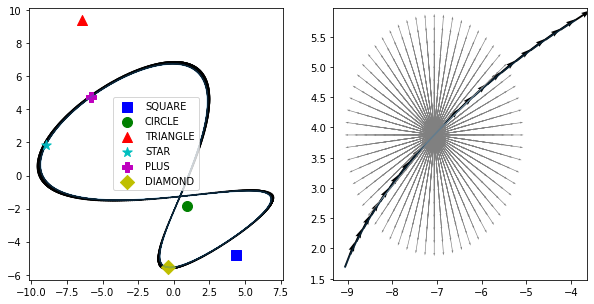

In [64]:
runT = 20*2
dt = 0.001
timesteps = np.arange(0, runT, dt)
#path,_ = generate_signal(T, dt, dims=2, rms=8,limit=0.05, seed=2)
#path = 3*np.vstack([np.sin(2*np.pi*timesteps/T),np.cos(2*np.pi*timesteps/T) - 1]).T
path,_ = generate_signal(runT/2, dt, dims=2, rms=6,limit=0.1, seed=2)

path = np.vstack([path,path])

rotation_matrix = lambda theta: np.stack([np.stack([np.cos(theta), -np.sin(theta)],axis=1),
           np.stack([np.sin(theta), np.cos(theta)], axis=1)], axis=1)
pathlen = path.shape[0]
vels = (1/dt)*( path[(np.minimum(floor(timesteps/dt) + 1, pathlen-1)).astype(int),:] -
               path[(np.minimum(floor(timesteps/dt), pathlen-2)).astype(int),:])
max_v = np.max(np.abs(vels))



item_names = ['SQUARE','CIRCLE','TRIANGLE','STAR','PLUS','DIAMOND']
items_markers = ["s","o","^","*","P","D"]
items_cols = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
num_items = 6
n_item_line = 3
line_pts = np.random.randint(0,path.shape[0],n_item_line)
item_locations = np.vstack([20*np.random.rand(num_items-n_item_line,2) - 10 ,np.array([path[line_pts,0],path[line_pts,1]]).T])



figure(figsize=(10,5))
subplot(1,2,1)
plot(path[:,0],path[:,1],alpha=0.3)
quiver(path[0::30,0],path[0::30,1], vels[0::30,0], vels[0::30,1], angles='xy', scale_units='xy',scale=2)
for i in np.arange(num_items):
    scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])
legend()


K_hex = np.array([[0,1], [np.sqrt(3)/2,-0.5], [-np.sqrt(3)/2,-0.5]])
K_scales2 = np.vstack([K_hex*i for i in np.linspace(0.1,2,10)])
thetas2 = np.arange(0,20)*2*np.pi/(20)
obj_vecs = (rotation_matrix(thetas2) @ K_scales2.T).transpose(1,2,0).T.reshape(-1,2)
n_V = obj_vecs.shape[0]


subplot(1,2,2)
nsubpath = 2000
plot(path[0:nsubpath,0],path[0:nsubpath,1],alpha=0.3)
quiver(path[0:nsubpath:100,0],path[0:nsubpath:100,1], vels[0:nsubpath:100,0], vels[0:nsubpath:100,1], angles='xy', scale_units='xy',scale=5)
quiver(np.tile(path[nsubpath//2,0],n_V),np.tile(path[nsubpath//2,1],n_V), 
       obj_vecs[:,0],obj_vecs[:,1], angles='xy', scale_units='xy',scale=1, color='grey')


In [65]:
vocab = spa.Vocabulary(d)
vocab.populate(';'.join(item_names[0:num_items]))

item_ssp = []
for i in np.arange(num_items):
    item_ssp.append(spa.SemanticPointer(data=(X**item_locations[i,0] * Y**item_locations[i,1]).v))
    if i==0:
        truemap = vocab[item_names[i]]*item_ssp[i]
    else:
        truemap = truemap + vocab[item_names[i]]*item_ssp[i]
        
n=(d-1)//2
Kt =  np.linspace(0.5,10,n)
FT = np.ones((n*2 + 1,), dtype="complex")
FT[0:n] = np.exp(1.j*Kt)
FT[-n:] = np.flip(np.conj(FT[0:n]))
FT = np.fft.ifftshift(FT)
T = SemanticPointer(data=np.fft.ifft(FT), algebra=HrrAlgebra())

n_timecells = 600

T_pos_dist = nengolib.stats.Rd()
T_pos = T_pos_dist.sample(n_timecells)*10
T_sorts = np.hstack([np.arange(n), np.random.randint(0, n - 1, size = n_timecells - n)])
T_encoders = np.zeros((n_timecells,d))
for i in np.arange(n_timecells):
    sub_mat = get_sub_SSP(T_sorts[i],n,sublen=1)
    proj_mat = proj_sub_SSP(T_sorts[i],n,sublen=1)
    Ti = SemanticPointer(data = sub_mat @ T.v)
    T_encoders[i,:] = n * proj_mat @ (Ti**T_pos[i,0]).v

/home/ns2dumon/anaconda3/lib/python3.7/site-packages/nengo_spa/semantic_pointer.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  self.v = np.array(data, dtype=float)
/home/ns2dumon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: ComplexWarning: Casting complex values to real discards the imaginary part


In [66]:
item_sp = np.array([vocab[item_names[i]].v for i in np.arange(num_items)])

intercept = (np.dot(item_sp, item_sp.T) - np.eye(num_items)).flatten().max()
intercept

0.06994224514455265

In [73]:
item_ssp_M = np.array([s.v for s in item_ssp])
intercept2 = (np.dot(item_ssp_M, item_ssp_M.T) - np.eye(num_items)).flatten().max()

n_G=1000
G_pos_dist = nengolib.stats.Rd()
G_pos = G_pos_dist.sample(n_G,2)*2*xy_rad - xy_rad

G_sorts = np.hstack([np.arange(N), np.random.randint(0, N - 1, size = n_G - N)])
G_encoders = np.zeros((n_G,d))
for i in np.arange(n_G):
    sub_mat = get_sub_SSP(G_sorts[i],N)
    proj_mat = proj_sub_SSP(G_sorts[i],N)
    Xi = SemanticPointer(data = sub_mat @ X.v)
    Yi = SemanticPointer(data = sub_mat @ Y.v)
    G_encoders[i,:] = N * proj_mat @ ((Xi**G_pos[i,0])*(Yi**G_pos[i,1])).v

/home/ns2dumon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


In [70]:
from nengo.networks import EnsembleArray
from nengo.exceptions import ObsoleteError


class InputGatedMemory(nengo.Network):
    def __init__(
        self,
        n_neurons,
        dimensions,
        feedback=1.0,
        difference_gain=1.0,
        recurrent_synapse=0.1,
        difference_synapse=None,
        add_gain = 1.0,
        normalize=False,
        **kwargs
    ):

        if "net" in kwargs:
            raise ObsoleteError("The 'net' argument is no longer supported.")
        kwargs.setdefault("label", "Input gated memory")
        super().__init__(**kwargs)

        if difference_synapse is None:
            difference_synapse = recurrent_synapse

        n_total_neurons = n_neurons * dimensions

        with self:
            self.input = nengo.Node(size_in=dimensions)
            
            def normalize(x):
                return feedback*x/np.maximum(1e-8,np.sum(x**2))
            
            
            # integrator to store value
            self.mem = EnsembleArray(n_neurons, dimensions, label="mem")
            if normalize:
                self.mem.output.output = lambda t, x: x
                nengo.Connection(
                    self.mem.output,
                    self.mem.input,
                    function=normalize,
                    synapse=recurrent_synapse,
                )
            else:
                nengo.Connection(
                    self.mem.output,
                    self.mem.input,
                    transform=feedback,
                    synapse=recurrent_synapse,
                )

            # calculate difference between stored value and input
            self.diff = EnsembleArray(n_neurons, dimensions, label="diff")
            nengo.Connection(self.mem.output, self.diff.input, transform=-1.0)
            
            nengo.Connection(self.input,self.diff.input)
            
            self.add = EnsembleArray(n_neurons, dimensions, label="add")
            
            nengo.Connection(self.input,self.add.input)
            nengo.Connection(
                self.add.output,
                self.mem.input,
                transform= add_gain,
                synapse=difference_synapse,
            )

            # feed difference into integrator
            nengo.Connection(
                self.diff.output,
                self.mem.input,
                transform=difference_gain,
                synapse=difference_synapse,
            )

            # gate difference (if gate==0, update stored value,
            # otherwise retain stored value)
            self.gate = nengo.Node(size_in=1)
            self.diff.add_neuron_input()
            nengo.Connection(
                self.gate,
                self.diff.neuron_input,
                transform=np.ones((n_total_neurons, 1)) * -10,
                synapse=None,
            )
            
            self.gate_inv = nengo.Node(size_in=1, output = lambda t, x: x==0)
            nengo.Connection(self.gate, self.gate_inv)
            self.add.add_neuron_input()
            nengo.Connection(
                self.gate_inv,
                self.add.neuron_input,
                transform=np.ones((n_total_neurons, 1)) * -10,
                synapse=None,
            )

            # reset input (if reset=1, remove all values, and set to 0)
            self.reset = nengo.Node(size_in=1)
            nengo.Connection(
                self.reset,
                self.mem.add_neuron_input(),
                transform=np.ones((n_total_neurons, 1)) * -3,
                synapse=None,
            )

        #self.input = self.diff.input
        self.output = self.mem.output

In [14]:

n_eval_pts = nengo.utils.builder.default_n_eval_points(n_timecells, d)
unif_dist = nengolib.stats.ScatteredHypersphere(True)
eval_t = 10*unif_dist.sample(n_eval_pts, 1)
eval_pts = ssp_vectorized(T.v.reshape(-1,1), eval_t).real.T

n_G = 1000 # number of grid cells
n_neurons = 1000

myK = K_scale_rotates


    
OVC_encoders = ssp_vectorized(np.vstack([X.v, Y.v]).T, obj_vecs).real.T

def exact_ssp(t):
    S = ((X**path[int(t/dt)-1,0])*(Y**path[int(t/dt)-1,1])).v
    return S
 

real_freqs = (vels @ myK.T)
scale_fac = 2/(np.max(real_freqs) - np.min(real_freqs))

tau = 0.1
model = nengo.Network(seed=1)
with model:
    # Velocity input
    stim_v = nengo.Node(lambda t: vels[int(t/dt)-1,:])
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_ssp(t) if t<10*dt else np.zeros((d,)))
    stimF = nengo.Node(lambda t: exact_Fssp(t) if t<10*dt else np.zeros((d-1,)))
    
    time_input = nengo.Node(lambda t: (T**t).v)
    
    time_cells = nengo.Ensemble(n_timecells, d, encoders = T_encoders, radius=np.sqrt(2), eval_points=eval_pts,label="time_cells")
    nengo.Connection(time_input, time_cells)
    
    # Path Int
    path_int = PathIntegrator(n_neurons, n_G, scale_fac=scale_fac, basis=[X,Y])

    nengo.Connection(stim, path_int.input_initial_SSP) #initialize
    nengo.Connection(stimF, path_int.input_initial_FSSP)
    nengo.Connection(stim_v, path_int.input_vel)
    
    
    # From vision
    def vision_sp_fun(t):
        S = exact_ssp(t)
        deltaS = np.zeros(d)
        for i in np.arange(num_items):
            if np.linalg.norm(path[int(t/dt)-1,:] - item_locations[i,:]) <= 2:
                recall_ssp = item_ssp[i] #truemap * ~vocab[item_names[i]]
                #deltaS = deltaS + (vocab[item_names[i]] * recall_ssp * ~spa.SemanticPointer(data=S.v)).v
                deltaS = deltaS + (recall_ssp * ~spa.SemanticPointer(data=S)).v
        return deltaS
    
    vision_sp_input = nengo.Node(vision_sp_fun)
    ovc_ens = nengo.Ensemble(n_V, d, encoders= OVC_encoders)
    nengo.Connection(vision_sp_input,ovc_ens)
    
    obj_ens = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d)
    nengo.Connection(path_int.output, obj_ens.input_a)
    nengo.Connection(ovc_ens, obj_ens.input_b)
    
    time_obj_ens = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d)
    nengo.Connection(obj_ens.output, time_obj_ens.input_a)
    nengo.Connection(time_cells, time_obj_ens.input_b)
    
        
    
    def normalize(x):
        return x/np.maximum(1e-8, np.sum(x**2))
    
   # memory = nengo.networks.EnsembleArray(n_neurons, d, 
    #                      ens_dimensions = 1,radius=1, label="memory")
    #nengo.Connection(time_obj_ens.output,memory.input)
    #for j in np.arange(d):
    #    nengo.Connection(memory.ea_ensembles[j], memory.ea_ensembles[j], function = normalize, synapse=tau)
    
    memory = InputGatedMemory(n_neurons, d, feedback=1.0, difference_gain=1.0, recurrent_synapse=tau)
    
    similarity = nengo.networks.Product(n_neurons, d)
    nengo.Connection(time_obj_ens.output, similarity.input_a)
    nengo.Connection(memory.output, similarity.input_b)
    gate = nengo.Node(size_in=d, size_out = 1, output=lambda t, x: np.sum(x) > 0.8)
    similarity.output.output = lambda t, x: x
    
    nengo.Connection(similarity.output, gate)
    
    nengo.Connection(time_obj_ens.output,memory.input)
    nengo.Connection(gate,memory.gate)
    
    # feed back into current location
    
    
    
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    ssp_p = nengo.Probe(path_int.output, synapse=.01)
    deltaS_p = nengo.Probe(ovc_ens , synapse=.01)
    obj_p = nengo.Probe(obj_ens.output , synapse=.01)
    t_p = nengo.Probe(time_cells , synapse=.01)
    obj_t_p = nengo.Probe(time_obj_ens.output , synapse=.01)
    memory_p = nengo.Probe(memory.output , synapse=.01)

    
nengo.utils.network.activate_direct_mode(model)
sim = nengo.Simulator(model)
sim.run(runT)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/ns2dumon/anaconda3/lib/python3.7/site-packages/nengo/builder/operator.py:776: ComplexWarning: Casting complex values to real discards the imaginary part
  output[...] = y


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

In [74]:

n_eval_pts = nengo.utils.builder.default_n_eval_points(n_timecells, d)
unif_dist = nengolib.stats.ScatteredHypersphere(True)
eval_t = 10*unif_dist.sample(n_eval_pts, 1)
eval_pts = ssp_vectorized(T.v.reshape(-1,1), eval_t).real.T

n_G = 1000 # number of grid cells
n_neurons = 1000

myK = K_scale_rotates


    
OVC_encoders = ssp_vectorized(np.vstack([X.v, Y.v]).T, obj_vecs).real.T

def exact_ssp(t):
    S = ((X**path[int(t/dt)-1,0])*(Y**path[int(t/dt)-1,1])).v
    return S
 

real_freqs = (vels @ myK.T)
scale_fac = 2/(np.max(real_freqs) - np.min(real_freqs))

tau = 0.1
model = nengo.Network(seed=1)
with model:
    # Velocity input
    stim_v = nengo.Node(lambda t: vels[int(t/dt)-1,:], label='velocity')
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_ssp(t) if t<10*dt else np.zeros((d,)))
    stimF = nengo.Node(lambda t: exact_Fssp(t) if t<10*dt else np.zeros((d-1,)))
    
    
    # Path Int
    path_int = PathIntegrator(n_neurons, n_G, scale_fac=scale_fac, basis=[X,Y])

    nengo.Connection(stim, path_int.input_initial_SSP) #initialize
    nengo.Connection(stimF, path_int.input_initial_FSSP)
    nengo.Connection(stim_v, path_int.input_vel)
    
    
    # From vision
    def vision_ssp_fun(t):
        S = exact_ssp(t)
        deltaS = np.zeros(d)
        for i in np.arange(num_items):
            if np.linalg.norm(path[int(t/dt)-1,:] - item_locations[i,:]) <= 2:
                recall_ssp = item_ssp[i] #truemap * ~vocab[item_names[i]]
                #deltaS = deltaS + (vocab[item_names[i]] * recall_ssp * ~spa.SemanticPointer(data=S.v)).v
                deltaS = deltaS + (recall_ssp * ~spa.SemanticPointer(data=S)).v
        return deltaS
    
    def vision_sp_fun(t):
        S = exact_ssp(t)
        deltaS = np.zeros(d)
        for i in np.arange(num_items):
            if np.linalg.norm(path[int(t/dt)-1,:] - item_locations[i,:]) <= 2:
                deltaS = deltaS + vocab[item_names[i]].v #* recall_ssp * ~spa.SemanticPointer(data=S.v)).v
        return deltaS
    
    
    vision_ssp_input = nengo.Node(vision_ssp_fun, label='obj_Dssp_input')
    vision_sp_input = nengo.Node(vision_sp_fun, label='obj_sp_input')
    
    ovc_ens = nengo.Ensemble(n_V, d, encoders= OVC_encoders, label='ovc')
    nengo.Connection(vision_ssp_input,ovc_ens)
    
    obj_ssp_ens = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d, label='obj_ssp')
    nengo.Connection(path_int.output, obj_ssp_ens.input_a)
    nengo.Connection(ovc_ens, obj_ssp_ens.input_b)
    
    obj_ens = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d, label='obj')
    nengo.Connection(vision_sp_input, obj_ens.input_a)
    nengo.Connection(obj_ssp_ens.output, obj_ens.input_b)
    
    
    obj_to_ssp_memory = nengo.Ensemble(n_neurons, d, intercepts = [intercept]*n_neurons, label='obj_to_ssp_mem')
    learning = nengo.Node(output=lambda t: -int(t >= runT / 2))
    recall1 = nengo.Node(size_in=d)
    
    # Learn the encoders/keys
    voja1 = nengo.Voja(learning_rate=5e-2, post_synapse=None)
    conn_in1 = nengo.Connection(vision_sp_input, obj_to_ssp_memory, synapse=None, learning_rule_type=voja1)
    nengo.Connection(learning, conn_in1.learning_rule, synapse=None)

    # Learn the decoders/values, initialized to a null function
    conn_out1 = nengo.Connection(
        obj_to_ssp_memory,
        recall1,
        learning_rule_type=nengo.PES(1e-3),
        function=lambda x: np.zeros(d),
    )

    # Create the error population
    error1 = nengo.Ensemble(n_neurons, d, label='error1')
    nengo.Connection(
        learning, error1.neurons, transform=[[10.0]] * n_neurons, synapse=None
    )

    # Calculate the error and use it to drive the PES rule
    nengo.Connection(obj_ssp_ens.output, error1, transform=-1, synapse=None)
    nengo.Connection(recall1, error1, synapse=None)
    nengo.Connection(error1, conn_out1.learning_rule)
    
    
    
    ssp_to_obj_memory = nengo.Ensemble(n_neurons, d, encoders=G_encoders,intercepts = [intercept2]*n_neurons, label='ssp_to_obj_mem')
    voja2 = nengo.Voja(learning_rate=5e-2, post_synapse=None)
    conn_in2 = nengo.Connection(obj_ssp_ens.output, ssp_to_obj_memory, synapse=None, learning_rule_type=voja2)
    nengo.Connection(learning, conn_in2.learning_rule, synapse=None)
    recall2 = nengo.Node(size_in=d)
    conn_out2 = nengo.Connection(
        ssp_to_obj_memory,
        recall2,
        learning_rule_type=nengo.PES(1e-3),
        function=lambda x: np.zeros(d),
    )

    error2 = nengo.Ensemble(n_neurons, d, label='error2')
    nengo.Connection(
        learning, error2.neurons, transform=[[10.0]] * n_neurons, synapse=None
    )
    nengo.Connection(vision_sp_input, error2, transform=-1, synapse=None)
    nengo.Connection(recall2, error2, synapse=None)
    nengo.Connection(error2, conn_out2.learning_rule)
    
    
    def normalize(x):
        return x/np.maximum(1e-9, np.sum(x**2))
    
    memory = nengo.networks.EnsembleArray(n_neurons, d, 
                          ens_dimensions = 1,radius=1, label="scene_memory")
    nengo.Connection(obj_ens.output,memory.input)
    for j in np.arange(d):
        nengo.Connection(memory.ea_ensembles[j], memory.ea_ensembles[j], function = normalize, synapse=tau)

    
    # feed back into current location
    
    
    
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    ssp_p = nengo.Probe(path_int.output, synapse=.01)
    deltaS_p = nengo.Probe(ovc_ens , synapse=.01)
    obj_ssp_p = nengo.Probe(obj_ssp_ens.output , synapse=.01)
    obj_p = nengo.Probe(obj_ens.output , synapse=.01)
    obj_to_ssp_memory_p = nengo.Probe(obj_to_ssp_memory, synapse=.01)
    ssp_to_obj_memory_p = nengo.Probe(obj_to_ssp_memory, synapse=.01)
    
    
    p_learning = nengo.Probe(learning, synapse=None)
    p_error1 = nengo.Probe(error1, synapse=0.005)
    p_recall1 = nengo.Probe(recall1, synapse=None)
    p_error2 = nengo.Probe(error2, synapse=0.005)
    p_recall2 = nengo.Probe(recall2, synapse=None)
    
    #t_p = nengo.Probe(time_cells , synapse=.01)
    #obj_t_p = nengo.Probe(time_obj_ens.output , synapse=.01)
    memory_p = nengo.Probe(memory.output , synapse=.01)

    
nengo.utils.network.activate_direct_mode(model)
sim = nengo.Simulator(model)
sim.run(runT)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/ns2dumon/anaconda3/lib/python3.7/site-packages/nengo/builder/operator.py:776: ComplexWarning: Casting complex values to real discards the imaginary part
  output[...] = y


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

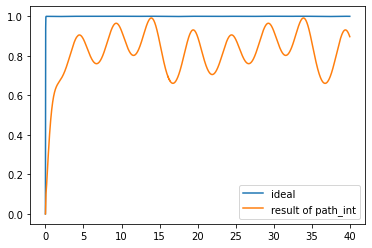

In [75]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
legend(["ideal","result of path_int"])

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:459: ComplexWarning: Casting complex values to real discards the imaginary part
  S_list[:,i] = np.fft.ifft(np.prod(np.fft.fft(basis, axis=0)**positions[i,:], axis=1), axis=0)


(-10.0, -2.0)

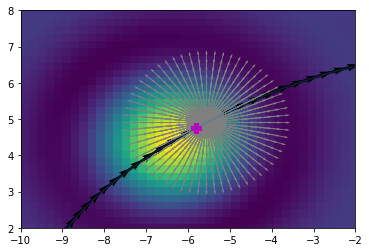

In [76]:
figure()
nsubpath = 3000

similarity_plot(X, Y, xs, ys, S0 = sim.data[obj_ssp_p][nsubpath//2,:])

plot(path[0:nsubpath,0],path[0:nsubpath,1],alpha=0.3)
quiver(path[0:nsubpath:100,0],path[0:nsubpath:100,1], vels[0:nsubpath:100,0], vels[0:nsubpath:100,1], angles='xy', scale_units='xy',scale=5)
quiver(np.tile(path[nsubpath//2,0],n_V),np.tile(path[nsubpath//2,1],n_V), 
       obj_vecs[:,0],obj_vecs[:,1], angles='xy', scale_units='xy',scale=1, color='grey')
for i in np.arange(num_items):
    scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])
ylim([2,8])
xlim([-10,-2])

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:459: ComplexWarning: Casting complex values to real discards the imaginary part
  S_list[:,i] = np.fft.ifft(np.prod(np.fft.fft(basis, axis=0)**positions[i,:], axis=1), axis=0)


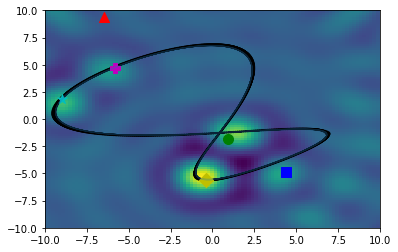

In [77]:
figure()
similarity_plot(X, Y, xs, ys, S0 = np.sum(sim.data[obj_ssp_p],axis=0))
plot(path[:,0],path[:,1],alpha=0.3)
quiver(path[0::30,0],path[0::30,1], vels[0::30,0], vels[0::30,1], angles='xy', scale_units='xy',scale=2)
for i in np.arange(num_items):
    scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:459: ComplexWarning: Casting complex values to real discards the imaginary part
  S_list[:,i] = np.fft.ifft(np.prod(np.fft.fft(basis, axis=0)**positions[i,:], axis=1), axis=0)


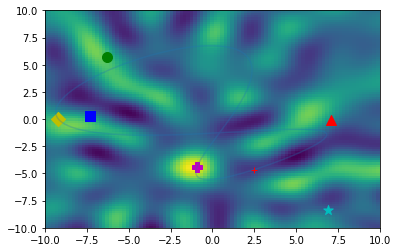

In [21]:
ex_t = 11000
ex_Obj = spa.SemanticPointer(data=sim.data[obj_t_p][ex_t,:])
ex_T = spa.SemanticPointer(data=sim.data[t_p][ex_t,:])


figure()
similarity_plot(X, Y, xs, ys, S0 = (ex_Obj * ~ex_T).v)
plot(path[:,0],path[:,1],alpha=0.3)
for i in np.arange(num_items):
    scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])
plot(path[ex_t,0],path[ex_t,1],'+r')

In [44]:
item_names


['SQUARE', 'CIRCLE', 'TRIANGLE', 'STAR', 'PLUS', 'DIAMOND']

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:459: ComplexWarning: Casting complex values to real discards the imaginary part
  S_list[:,i] = np.fft.ifft(np.prod(np.fft.fft(basis, axis=0)**positions[i,:], axis=1), axis=0)


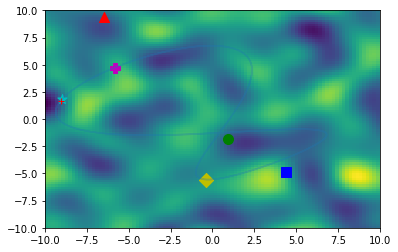

In [78]:
ex_t = len(sim.trange())-1
ex_M = spa.SemanticPointer(data=sim.data[memory_p][ex_t,:])
ex_Obj = vocab['PLUS']
#ex_T = spa.SemanticPointer(data=sim.data[t_p][ex_t,:])


figure()
similarity_plot(X, Y, xs, ys, S0 = (ex_M * ~ex_Obj).v)
plot(path[:,0],path[:,1],alpha=0.3)
for i in np.arange(num_items):
    scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])
plot(path[ex_t,0],path[ex_t,1],'+r')

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:459: ComplexWarning: Casting complex values to real discards the imaginary part
  S_list[:,i] = np.fft.ifft(np.prod(np.fft.fft(basis, axis=0)**positions[i,:], axis=1), axis=0)


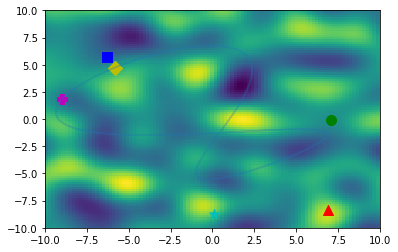

In [41]:
Msum = np.sum(sim.data[memory_p],axis=0)
#np.zeros(d)
#for t in np.arange(len(sim.trange())):
#    Mt = (spa.SemanticPointer(data=sim.data[memory_p][t,:]) * ~spa.SemanticPointer(data=sim.data[t_p][t,:])).v
#    Msum = Msum + Mt


figure()
similarity_plot(X, Y, xs, ys, S0 = Msum )
plot(path[:,0],path[:,1],alpha=0.3)
for i in np.arange(num_items):
    scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])
#plot(path[ex_t,0],path[ex_t,1],'+r')

In [ ]:
## Want: to continuously sum the obj_ens output and normalize
# - could use a GC pop as an integrator? but what about when I want to intorduce OBJ SPs? 
# - change add gain?

In [54]:
sim.data[p_recall].shape

(40000, 151)

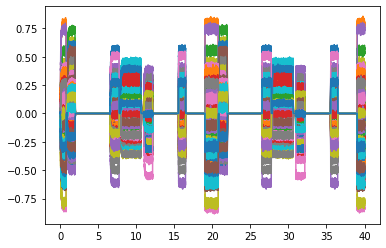

In [79]:
plt.figure()
plt.plot(sim.trange(), sim.data[obj_to_ssp_memory_p]);

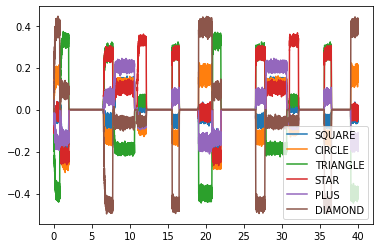

In [80]:
plt.figure()
plt.plot(sim.trange(), sim.data[obj_to_ssp_memory_p] @ np.array([s.v for s in item_ssp]).T)
plt.legend(item_names)

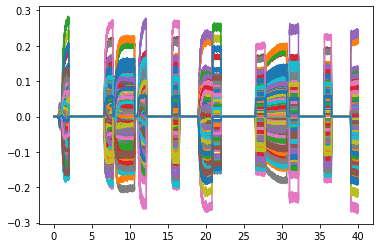

In [82]:
plt.figure()
plt.plot(sim.trange(), sim.data[p_recall2]);

In [ ]:
plt.figure()
plt.plot(sim.trange(), sim.data[obj_to_ssp_memory_p])

In [64]:
model = nengo.Network(seed=1)
with model:
    # Velocity input
    stim_v = nengo.Node(lambda t: vels[int(t/dt)-1,:])
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_ssp(t) if t<10*dt else np.zeros((d,)))
    stimF = nengo.Node(lambda t: exact_Fssp(t) if t<10*dt else np.zeros((d-1,)))
    
    
    # Path Int
    path_int = PathIntegrator(n_neurons, n_G, scale_fac=scale_fac, basis=[X,Y])

    nengo.Connection(stim, path_int.input_initial_SSP) #initialize
    nengo.Connection(stimF, path_int.input_initial_FSSP)
    nengo.Connection(stim_v, path_int.input_vel)
    
    
    # From vision
    def vision_sp_fun(t):
        S = exact_ssp(t)
        deltaS = np.zeros(d)
        for i in np.arange(num_items):
            if np.linalg.norm(path[int(t/dt)-1,:] - item_locations[i,:]) <= 2:
                recall_ssp = item_ssp[i] #truemap * ~vocab[item_names[i]]
                #deltaS = deltaS + (vocab[item_names[i]] * recall_ssp * ~spa.SemanticPointer(data=S.v)).v
                deltaS = deltaS + (recall_ssp * ~spa.SemanticPointer(data=S)).v
        return deltaS
    
    vision_sp_input = nengo.Node(vision_sp_fun)
    ovc_ens = nengo.Ensemble(n_V, d, encoders= OVC_encoders)
    nengo.Connection(vision_sp_input,ovc_ens)
    
    obj_ens = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d)
    nengo.Connection(path_int.output, obj_ens.input_a)
    nengo.Connection(ovc_ens, obj_ens.input_b)
    
        
    
    def normalize(x):
        return x/np.maximum(1e-8, np.sum(x**2))
    
    memory = InputGatedMemory(n_neurons, d, feedback=1.0, difference_gain=0.1, recurrent_synapse=tau)
    
    similarity = nengo.networks.Product(n_neurons, d)
    nengo.Connection(obj_ens.output, similarity.input_a, synapse = 0.2)
    nengo.Connection(memory.output, similarity.input_b, synapse = 0.2)
    gate = nengo.Node(size_in=d, size_out = 1, output=lambda t, x: 0)#np.sum(x) > 0.8)
    similarity.output.output = lambda t, x: x
    
    nengo.Connection(similarity.output, gate)
    
    nengo.Connection(obj_ens.output,memory.input)
    nengo.Connection(gate,memory.gate)
    
    # feed back into current location
    
    
    
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    ssp_p = nengo.Probe(path_int.output, synapse=.01)
    deltaS_p = nengo.Probe(ovc_ens , synapse=.01)
    obj_p = nengo.Probe(obj_ens.output , synapse=.01)
    memory_p = nengo.Probe(memory.output , synapse=.01)

    
nengo.utils.network.activate_direct_mode(model)
sim = nengo.Simulator(model)
sim.run(runT)

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:993: ComplexWarning: Casting complex values to real discards the imaginary part
  G_encoders[i,:] = N * proj_mat @ ((Xi**G_pos[i,0])*(Yi**G_pos[i,1])).v
/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:459: ComplexWarning: Casting complex values to real discards the imaginary part
  S_list[:,i] = np.fft.ifft(np.prod(np.fft.fft(basis, axis=0)**positions[i,:], axis=1), axis=0)
/home/ns2dumon/anaconda3/lib/python3.7/site-packages/nengo_spa/semantic_pointer.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  self.v = np.array(data, dtype=float)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/ns2dumon/anaconda3/lib/python3.7/site-packages/nengo/builder/operator.py:776: ComplexWarning: Casting complex values to real discards the imaginary part
  output[...] = y


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:459: ComplexWarning: Casting complex values to real discards the imaginary part
  S_list[:,i] = np.fft.ifft(np.prod(np.fft.fft(basis, axis=0)**positions[i,:], axis=1), axis=0)


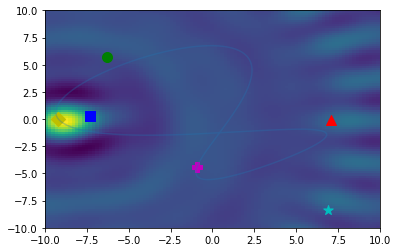

In [66]:
figure()
similarity_plot(X, Y, xs, ys, S0 = sim.data[memory_p][-1,:] )
plot(path[:,0],path[:,1],alpha=0.3)
for i in np.arange(num_items):
    scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])

In [37]:
n_oscs = d//2
real_ids = np.arange(1,n_oscs*3,3)
imag_ids = np.arange(2,n_oscs*3,3)
S_ids = np.zeros(n_oscs*2 + 1, dtype=int)
S_ids[0:d//2] = real_ids
S_ids[d//2:(n_oscs*2)] = imag_ids
S_ids[-1] = n_oscs*3 
i_S_ids = np.argsort(S_ids)

In [57]:

n_eval_pts = nengo.utils.builder.default_n_eval_points(n_timecells, d)
unif_dist = nengolib.stats.ScatteredHypersphere(True)
eval_t = 10*unif_dist.sample(n_eval_pts, 1)
eval_pts = ssp_vectorized(T.v.reshape(-1,1), eval_t).real.T

n_G = 1000 # number of grid cells
n_neurons = 1000

myK = K_scale_rotates


    
OVC_encoders = ssp_vectorized(np.vstack([X.v, Y.v]).T, obj_vecs).real.T

def exact_ssp(t):
    S = ((X**path[int(t/dt)-1,0])*(Y**path[int(t/dt)-1,1])).v
    return S
 

real_freqs = (vels @ myK.T)
scale_fac = 2/(np.max(real_freqs) - np.min(real_freqs))

tau = 0.1
model = nengo.Network(seed=1)
with model:
    # Velocity input
    stim_v = nengo.Node(lambda t: vels[int(t/dt)-1,:])
    S_real = nengo.Node(exact_ssp) # just for probes
    stim = nengo.Node(lambda t: exact_ssp(t) if t<10*dt else np.zeros((d,)))
    stimF = nengo.Node(lambda t: exact_Fssp(t) if t<10*dt else np.zeros((d-1,)))
    
    time_input = nengo.Node(lambda t: (T**t).v)
    
    time_cells = nengo.Ensemble(n_timecells, d, encoders = T_encoders, radius=np.sqrt(2), eval_points=eval_pts,label="time_cells")
    nengo.Connection(time_input, time_cells)
    
    # Path Int
    path_int = PathIntegrator(n_neurons, n_G, scale_fac=scale_fac, basis=[X,Y])

    nengo.Connection(stim, path_int.input_initial_SSP) #initialize
    nengo.Connection(stimF, path_int.input_initial_FSSP)
    nengo.Connection(stim_v, path_int.input_vel)
    
    
    # From vision
    def vision_sp_fun(t):
        S = exact_ssp(t)
        deltaS = np.zeros(d)
        for i in np.arange(num_items):
            if np.linalg.norm(path[int(t/dt)-1,:] - item_locations[i,:]) <= 2:
                recall_ssp = item_ssp[i] #truemap * ~vocab[item_names[i]]
                #deltaS = deltaS + (vocab[item_names[i]] * recall_ssp * ~spa.SemanticPointer(data=S.v)).v
                deltaS = deltaS + (recall_ssp * ~spa.SemanticPointer(data=S)).v
        return deltaS
    
    vision_sp_input = nengo.Node(vision_sp_fun)
    ovc_ens = nengo.Ensemble(n_V, d, encoders= OVC_encoders)
    nengo.Connection(vision_sp_input,ovc_ens)
    
    obj_ens = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d)
    nengo.Connection(path_int.output, obj_ens.input_a)
    nengo.Connection(ovc_ens, obj_ens.input_b)
    
        
    memory = InputGatedMemory(n_neurons, d, feedback=1.0, difference_gain=0.5, add_gain=0.5,
                              recurrent_synapse=tau, normalize=True)
    
    similarity = nengo.networks.Product(n_neurons, d)
    nengo.Connection(obj_ens.output, similarity.input_a)
    nengo.Connection(memory.output, similarity.input_b)
    gate = nengo.Node(size_in=d, size_out = 1, output=lambda t, x: np.sum(x) > 0.8)
    similarity.output.output = lambda t, x: x
    
    nengo.Connection(similarity.output, gate)
    
    nengo.Connection(obj_ens.output,memory.input)
    nengo.Connection(gate,memory.gate)
    
    # feed back into current location
    other_SSP_est = spa.networks.CircularConvolution(n_neurons=n_neurons, dimensions=d,invert_b = True)
    nengo.Connection(memory.output, obj_ens.input_a)
    nengo.Connection(ovc_ens, obj_ens.input_b)
    
    diff = EnsembleArray(n_neurons, d, label="diff")
    nengo.Connection(path_int.output, diff.input, transform=-1.0)
    nengo.Connection(other_SSP_est.output, diff.input)
    
    i_to_SSP = path_int.get_from_SSP_mat(d)
    nengo.Connection(diff.output, path_int.osc.input[i_S_ids[0:-1]], transform = 0.5*i_to_SSP)
    
    
    
    real_ssp_p = nengo.Probe(S_real, synapse=.01)
    ssp_p = nengo.Probe(path_int.output, synapse=.01)
    deltaS_p = nengo.Probe(ovc_ens , synapse=.01)
    obj_p = nengo.Probe(obj_ens.output , synapse=.01)
    memory_p = nengo.Probe(memory.output , synapse=.01)

    
nengo.utils.network.activate_direct_mode(model)
sim = nengo.Simulator(model)
sim.run(runT)

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:459: ComplexWarning: Casting complex values to real discards the imaginary part
  S_list[:,i] = np.fft.ifft(np.prod(np.fft.fft(basis, axis=0)**positions[i,:], axis=1), axis=0)
/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:993: ComplexWarning: Casting complex values to real discards the imaginary part
  G_encoders[i,:] = N * proj_mat @ ((Xi**G_pos[i,0])*(Yi**G_pos[i,1])).v
/home/ns2dumon/anaconda3/lib/python3.7/site-packages/nengo_spa/semantic_pointer.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  self.v = np.array(data, dtype=float)


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/ns2dumon/anaconda3/lib/python3.7/site-packages/nengo/builder/operator.py:776: ComplexWarning: Casting complex values to real discards the imaginary part
  output[...] = y


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

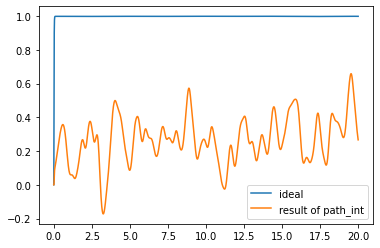

In [58]:
figure()
plot(sim.trange(),np.sum(sim.data[real_ssp_p]*sim.data[real_ssp_p], axis=1))
plot(sim.trange(),np.sum(sim.data[ssp_p]*sim.data[real_ssp_p], axis=1))
legend(["ideal","result of path_int"])

/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:459: ComplexWarning: Casting complex values to real discards the imaginary part
  S_list[:,i] = np.fft.ifft(np.prod(np.fft.fft(basis, axis=0)**positions[i,:], axis=1), axis=0)


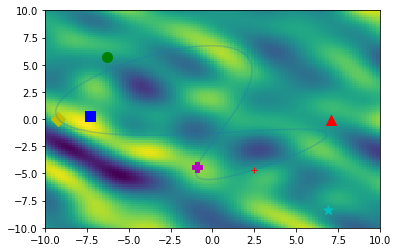

In [59]:
ex_t = 11000


figure()
similarity_plot(X, Y, xs, ys, S0 = sim.data[memory_p][ex_t,:])
plot(path[:,0],path[:,1],alpha=0.3)
for i in np.arange(num_items):
    scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])
plot(path[ex_t,0],path[ex_t,1],'+r')

In [79]:
from matplotlib import animation, rc
from IPython.display import HTML

In [90]:
ts = sim.trange()
xx,yy = np.meshgrid(xs,ys)
basis = np.vstack([X.v, Y.v]).T.real
positions = np.vstack([xx.reshape(-1), yy.reshape(-1)]).T
position0 = np.array([0,0])
S0 = (spa.SemanticPointer(data=sim.data[memory_p][0,:]) * ~(spa.SemanticPointer(data=(T**0).v))).v
sim_dots0, S_list = similarity_values(basis,  positions, position0 = position0, S0 =S0)

def init():
    similarity_plot(X, Y, xs, ys, S0 = S0, S_list=S_list)
    plot(path[:,0],path[:,1],color="k")
    #quiver(path[0::30,0],path[0::30,1], vels[0::30,0], vels[0::30,1], angles='xy', scale_units='xy',scale=2)
    for i in np.arange(num_items):
        scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])
        
def animate(j):
    Sj = (spa.SemanticPointer(data=sim.data[memory_p][j,:]) * ~(spa.SemanticPointer(data=(T**ts[j]).v ))).v
    similarity_plot(X, Y, xs, ys, S0 = Sj, S_list=S_list)
    plot(path[:,0],path[:,1],color="k")
    for i in np.arange(num_items):
        scatter(item_locations[i,0],item_locations[i,1],
            marker=items_markers[i],s=100,label=item_names[i],c=items_cols[i])


anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(ts), interval=500, blit=False)

/home/ns2dumon/anaconda3/lib/python3.7/site-packages/nengo_spa/semantic_pointer.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  self.v = np.array(data, dtype=float)
/home/ns2dumon/Documents/GitHub/ssp-grid-cells/notebooks/ssp_grid_cell_utils.py:459: ComplexWarning: Casting complex values to real discards the imaginary part
  S_list[:,i] = np.fft.ifft(np.prod(np.fft.fft(basis, axis=0)**positions[i,:], axis=1), axis=0)
